#### Part 2: Spatial interaction models

- Using OD matrix
- Remember to drop Battersea Park 

- (a) Models and calibrations
    - briefly introduce the spaial interaction models using equations and defining the terms, taking particular care in explaining the role of the parametres
    - select a spatial interaction model and calibrate the parameter for the cost function, using the information of population, jobs, and flows 
        - **doubly constrained model**
        - **with negative exponential function model**
    - to justify the model selected

- (b) Scenarios
    - scenario a: assume that Canary Wharf has a 50% decrease in jobs after Brexit, using the calibrated parameter beta, compute the new flows for scenario a (make sure the number of commuters is conserved, explain how you ensured this)
        - we should use negative exponential model
        - because it is bettwe represented for travelling/ commuting far away, particularly true for the london underground
        - less rapid decrease in flows with the increasing distance
        - people are willing to travel for a longer distance among the london underground network, to save living costs (renting), to live further away and commute for a further distance
    - scenario b: assume there is a significant increase in the cost of transport. Select 2 values for the parameter in the cost function reflecting scenario B, recompute the distribution of flows.
        - to increase the value of beta (the greater the beta value to more influencial on the model)
        - the increase in beta means an increase in costs for transportation
    - discuess how the flows change for the 3 different situations: scenario a, b with two selections of parameters; which scenario would have more impact in the redistribution of flows?

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

In [51]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

In [52]:
OD = pd.read_csv("london_flows_latest.csv")
OD

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [53]:
# to filter out rows and columns that contains zero
filtered_OD = OD[OD['flows']!= 0]
filtered_OD = filtered_OD[filtered_OD['distance'] != 0]
filtered_OD = filtered_OD[(filtered_OD['station_origin'] != 'Battersea Park') & (filtered_OD['station_destination'] != 'Battersea Park')]


In [54]:

x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    filtered_OD[f"log_{x}"] = np.log(filtered_OD[x])
    log_x_vars.append(f"log_{x}")

#filtered_OD = OD[OD['flows']!= 0]
#filtered_OD = filtered_OD[(filtered_OD['station_origin'] != 'Battersea Park') & (filtered_OD['station_destination'] != 'Battersea Park')]



### Testing the unconstrained model.

In [60]:

#create the formula
formula = 'flows ~ log_population + log_jobs + log_distance'

#run the regression
uncosim = smf.glm(formula = formula, 
                  data=filtered_OD, 
                  family=sm.families.Poisson()).fit()


In [61]:
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43941
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1675e+06
Date:                Mon, 22 Apr 2024   Deviance:                   2.1627e+06
Time:                        13:00:28   Pearson chi2:                 4.13e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0646      0.014   -223.

The K coefficient is **-3.0646**.

The alpha value for origin is **0.6973**.

The gamma value for destination is **0.7037**.

The beta value for cost function is **-0.5961**.

In [62]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [63]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
filtered_OD["unconstrainedEst"] = np.exp(K 
                                       + alpha*filtered_OD["log_population"] 
                                       + gamma*filtered_OD["log_jobs"] 
                                       - beta*filtered_OD["log_distance"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
filtered_OD["fitted"] = predictions_summary_frame["mean"]

In [64]:
filtered_OD["unconstrainedEst"] = round(filtered_OD["unconstrainedEst"], 0)
#convert to integers
filtered_OD["unconstrainedEst"] = filtered_OD["unconstrainedEst"].astype(int)
#check that the sum of these estimates make sense
sum(filtered_OD["unconstrainedEst"])

1542307

In [65]:
CalcRSquared(filtered_OD["flows"], filtered_OD["unconstrainedEst"])

0.3114155959169925

In [66]:
CalcRMSE(filtered_OD["flows"], filtered_OD["unconstrainedEst"])

128.175

### Testing the origin-constrained model.

In [71]:
formula = 'flows ~ station_origin + log_jobs + log_distance-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=filtered_OD, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43545
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1409e+05
Date:                Mon, 22 Apr 2024   Deviance:                   1.6560e+06
Time:                        13:00:46   Pearson chi2:                 2.41e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Create some Oi and Dj columns to store the total out and in flow matric margins in them.

In [72]:
O_i1 = pd.DataFrame(filtered_OD.groupby(["station_origin"])["flows"].agg(np.sum))
O_i1.rename(columns={"flows":"O_i1"}, inplace = True)
filtered_OD = filtered_OD.merge(O_i1, on = "station_origin", how = "left" )

D_j1 = pd.DataFrame(filtered_OD.groupby(["station_destination"])["flows"].agg(np.sum))
D_j1.rename(columns={"flows":"D_j1"}, inplace = True)
filtered_OD = filtered_OD.merge(D_j1, on = "station_destination", how = "left" )

In [73]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
filtered_OD = filtered_OD.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
filtered_OD.drop(columns = ["coef"], inplace = True)
filtered_OD.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst_exp,fitted_exp,unconstrainedEst,fitted,O_i4,D_j4,alpha_i_x,O_i1,D_j1,alpha_i_y
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.783844,1.813270,1,1.331852,599,442,-2.491868,599,442,3.270351
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.008289,3.615076,3,2.882125,599,665,-2.491868,599,665,3.270351
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,108.442525,69.882583,57,56.518643,599,58772,-2.491868,599,58772,3.270351
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,43.317439,35.742874,36,36.062256,599,15428,-2.491868,599,15428,3.270351
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,7.543166,4.232594,3,3.120065,599,1208,-2.491868,599,1208,3.270351


In [74]:
filtered_OD["prodsimest1_exp"] = np.exp(filtered_OD["alpha_i"]+gamma*filtered_OD["log_jobs"] 
                                 - beta*filtered_OD["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
filtered_OD.head(10)

KeyError: 'alpha_i'

In [ ]:
CalcRSquared(filtered_OD["flows"], filtered_OD["prodsimest1_exp"])

0.11872628892934074

In [ ]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

In [ ]:
alpha_i

station_origin[Abbey Road]          3.270351
station_origin[Acton Central]       5.008886
station_origin[Acton Town]          4.397394
station_origin[Aldgate]             3.361125
station_origin[Aldgate East]        3.408728
                                      ...   
station_origin[Wood Street]         5.672160
station_origin[Woodford]            4.955425
station_origin[Woodgrange Park]     5.320215
station_origin[Woodside Park]       4.496709
station_origin[Woolwich Arsenal]    6.701868
Length: 398, dtype: float64

In [ ]:
gamma

0.7301699265793905

In [ ]:
beta

0.8151874614788169

Generating our estimates.

In [ ]:
filtered_OD["prodsimest1"] = np.exp(filtered_OD["alpha_i"]+gamma*filtered_OD["log_jobs"] 
                                 - beta*filtered_OD["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
filtered_OD.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst,fitted,O_i1,D_j1,alpha_i,prodsimest1
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,1.331852,599,442,3.270351,1.406918
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,2.882125,599,665,3.270351,3.677350
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,57,56.518643,599,58772,3.270351,76.062924
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,36,36.062256,599,15428,3.270351,56.123931
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,3.120065,599,1208,3.270351,3.568414
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,4,3.506225,599,1748,3.270351,3.841726
6,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,2.470543,599,850,3.270351,2.813752
7,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,3,2.639878,599,611,3.270351,3.326081
8,Abbey Road,East India,2,599,1522,3384.141666,6.395262,7.327781,8.126856,6,5.509198,599,1522,3.270351,7.359304
9,Abbey Road,Island Gardens,2,599,691,7706.296370,6.395262,6.538140,8.949793,2,1.935092,599,691,3.270351,2.113923


In [ ]:
CalcRSquared(filtered_OD["flows"], filtered_OD["prodsimest1"])

0.393730485083089

The r-squared value for the origin constrained model is 0.394.

In [ ]:
CalcRMSE(filtered_OD["flows"], filtered_OD["prodsimest1"])

120.146

### Test for destination constrained model.

In [ ]:
attr_form = 'flows ~ station_destination + log_population + log_distance-1'
#run a destination constrained sim
attrSim = smf.glm(formula = attr_form, data=filtered_OD, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43545
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0404e+06
Date:                Thu, 18 Apr 2024   Deviance:                   1.9085e+06
Time:                        12:14:33   Pearson chi2:                 3.05e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

The calibrated beta value for this destination constrained model is -0.6065.

In [ ]:
predictions = attrSim.get_prediction(filtered_OD[["station_destination", "log_population", "log_distance"]])
predictions_summary_frame = predictions.summary_frame()
filtered_OD["attrsimFitted"] = round(predictions_summary_frame["mean"],0)

In [ ]:
filtered_OD

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst,fitted,O_i1,D_j1,alpha_i,prodsimest1,attrsimFitted
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,1.331852,599,442,3.270351,1.406918,4.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,2.882125,599,665,3.270351,3.677350,4.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,57,56.518643,599,58772,3.270351,76.062924,76.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,36,36.062256,599,15428,3.270351,56.123931,37.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,3.120065,599,1208,3.270351,3.568414,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,25,25.463983,7892,3342,6.701868,131.612217,84.0
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,47,46.695352,7892,5487,6.701868,268.799374,44.0
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,7,7.002274,7892,400,6.701868,36.861579,8.0
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,17,17.381639,7892,893,6.701868,106.060284,37.0


In [ ]:
CalcRSquared(filtered_OD["flows"], filtered_OD["attrsimFitted"])

0.34823921191709895

The calculated r-value for the destination constrained model is 0.348.

Destination constrained with negative exponential.

In [ ]:
attr_form_exp = 'flows ~ station_destination + log_population + distance-1'
#run a destination constrained sim
attrSim_exp = smf.glm(formula = attr_form_exp, data=filtered_OD, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43545
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.9596e+05
Date:                Sat, 20 Apr 2024   Deviance:                   1.8197e+06
Time:                        13:04:07   Pearson chi2:                 2.87e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [ ]:
attrSim_exp.params[-1]

-9.38995910208242e-05

In [ ]:
predictions_exp = attrSim_exp.get_prediction(filtered_OD[["station_destination", "log_population", "distance"]])
predictions_summary_frame_exp = predictions.summary_frame()
filtered_OD["attrsimFitted_exp"] = round(predictions_summary_frame_exp["mean"],0)

In [ ]:
CalcRSquared(filtered_OD["flows"], filtered_OD["attrsimFitted_exp"])

0.34774410254611543

Test for doubly constrained model with negative exponential.

In [ ]:
# Run a doubly constrained SIM with a negative exponential cost function.
doubsim_form_expo = "flows ~ station_origin + station_destination + distance -1"
doubsim1 = smf.glm(formula=doubsim_form_expo, data = filtered_OD, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43149
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.6208e+05
Date:                Thu, 18 Apr 2024   Deviance:                   1.3520e+06
Time:                        12:15:03   Pearson chi2:                 1.74e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [ ]:
filtered_OD["doubsimfitted"] = np.round(doubsim1.mu,0)

In [ ]:
beta = doubsim1.params[795]

In [ ]:
beta

-0.00014481467724951992

The calibrate parameter for the cost functiong (- beta) is -0.0001/ -0.00014.

In [ ]:
CalcRSquared(filtered_OD["flows"],filtered_OD["doubsimfitted"])

0.4997778698538434

The r-squared value for this model is -0.5/ 0.4998.

In [ ]:
CalcRMSE(filtered_OD["flows"],filtered_OD["doubsimfitted"])

109.598

The calcultaed RMSE of this model is 109.598.

In [ ]:
doubsim_form_power = "flows ~ station_origin + station_destination + log_distance -1"
doubsim2 = smf.glm(formula=doubsim_form_power, data = filtered_OD, family = sm.families.Poisson()).fit()
print(doubsim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43149
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.6312e+05
Date:                Sat, 20 Apr 2024   Deviance:                   1.5540e+06
Time:                        12:50:32   Pearson chi2:                 2.10e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [ ]:
filtered_OD["doubsimfitted_pow"] = np.round(doubsim2.mu,0)

In [ ]:
beta_pow = doubsim2.params[-1]
beta_pow

-0.8473602005716566

In [ ]:
CalcRSquared(filtered_OD["flows"],filtered_OD["doubsimfitted_pow"])

0.41893772760573633

The r-squared values for the doubly constrained with inverse power is 0.419

Scenario:

Scenario A:
- assume that canary wharf has a 50% decrease in jobs after Brexit, using calibrate parameter beta, compute the new flow for scenario A
- make sure the number of commuters is conserved, and explain how you ensured this

Scenario B:
- assume that there is a significant increase in the cost of transport
- select 2 values for the parameter in the cost function reflecting scenario B
- recompute the distribution of flows

IV3
- discuss how the flows change for the 3 different situations: scenario A and scenario B with two selections of parameters
- which scenario would have more impact in the redistribution of flows
- explain and justify your answers using the results of the analysis


### Scenario A: job reduction in canary wharf

In [75]:
canary_half = pd.read_csv("london_flows_latest.csv")

In [76]:
canary_half = canary_half[canary_half['flows']!= 0]
canary_half = canary_half[canary_half['distance'] != 0]
canary_half = canary_half[(canary_half['station_origin'] != 'Battersea Park') & (canary_half['station_destination'] != 'Battersea Park')]

In [77]:
canary_half

,station_origin,station_destination,flows,population,jobs,distance
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [78]:
x_variables = ["population", "distance", "jobs"]
log_x_vars = []
for x in x_variables:
    canary_half[f"log_{x}"] = np.log(canary_half[x])
    log_x_vars.append(f"log_{x}")

In [79]:
prodSim_canary = 'flows ~ station_origin + log_jobs + distance-1'
#run a destination constrained sim
prodSim_canary = smf.glm(formula = prodSim_canary, data=canary_half, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim_canary.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43545
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.2314e+05
Date:                Mon, 22 Apr 2024   Deviance:                   1.4741e+06
Time:                        13:01:30   Pearson chi2:                 2.08e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [81]:
alpha_i1 = prodSim_canary.params[0:-2]
gamma = prodSim_canary.params[-2]
beta_prodsim_org = -prodSim_canary.params[-1]

In [82]:
alpha_i1

station_origin[Abbey Road]         -2.491868
station_origin[Acton Central]      -0.799247
station_origin[Acton Town]         -1.391881
station_origin[Aldgate]            -2.523238
station_origin[Aldgate East]       -2.532117
                                      ...   
station_origin[Wood Street]        -0.184360
station_origin[Woodford]           -0.464289
station_origin[Woodgrange Park]    -0.592262
station_origin[Woodside Park]      -0.995413
station_origin[Woolwich Arsenal]    0.711189
Length: 398, dtype: float64

In [ ]:
beta_prodsim_org

0.0001437329848913075

In [83]:
canary_half.sort_values(by = 'flows', ascending = False)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs
55949,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,7.841082,11.271478
55974,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,8.913817,10.981421
50095,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,8.809633,11.020627
32654,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,8.644567,10.981421
54825,Victoria,Oxford Circus,5181,37517,44368,2220.166284,10.532549,7.705337,10.700274
...,...,...,...,...,...,...,...,...,...
41100,Preston Road,Kennington,1,2358,1161,18399.933202,7.765569,9.820102,7.057037
41104,Preston Road,Kingsbury,1,2358,1018,4336.506724,7.765569,8.374824,6.925595
41109,Preston Road,Latimer Road,1,2358,1109,17416.439206,7.765569,9.765170,7.011214
41115,Preston Road,Maida Vale,1,2358,949,15764.456495,7.765569,9.665513,6.855409


In [84]:
canary_wharf_rows = canary_half[canary_half['station_destination'] == 'Canary Wharf']
canary_wharf_rows

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348,10.981421
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,8.228177,9.923200,10.981421
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,7.967627,8.789419,10.981421
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,8.062118,8.542471,10.981421
817,All Saints,Canary Wharf,67,740,58772,1340.088733,6.606650,7.200491,10.981421
...,...,...,...,...,...,...,...,...,...
60428,Wimbledon Park,Canary Wharf,27,1664,58772,20878.891995,7.416980,9.946494,10.981421
60595,Wood Green,Canary Wharf,64,6667,58772,16849.246595,8.804925,9.732061,10.981421
61062,Woodford,Canary Wharf,192,4868,58772,13963.787075,8.490438,9.544223,10.981421
61294,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,8.036897,10.014875,10.981421


In [85]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total

O_i2 = pd.DataFrame(canary_half.groupby(["station_origin"])["flows"].agg(np.sum))
O_i2.rename(columns={"flows":"O_i2"}, inplace = True)
canary_half = canary_half.merge(O_i2, on = "station_origin", how = "left" )

D_j2 = pd.DataFrame(canary_half.groupby(["station_destination"])["flows"].agg(np.sum))
D_j2.rename(columns={"flows":"D_j2"}, inplace = True)
canary_half = canary_half.merge(D_j2, on = "station_destination", how = "left" )

In [86]:
canary_half

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,9.049012,6.091310,599,442
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,8.236275,6.499787,599,665
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348,10.981421,599,58772
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,7.709274,9.643939,599,15428
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,8.807842,7.096721,599,1208
...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,9.503144,8.114325,7892,3342
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,9.071245,8.610137,7892,5487
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,9.162905,5.991465,7892,400
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,8.585832,6.794587,7892,893


In [87]:
coefs = pd.DataFrame(prodSim_canary.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i1", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
canary_half = canary_half.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
canary_half.drop(columns = ["coef"], inplace = True)
canary_half.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,9.049012,6.091310,599,442,-2.491868
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,8.236275,6.499787,599,665,-2.491868
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348,10.981421,599,58772,-2.491868
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,7.709274,9.643939,599,15428,-2.491868
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,8.807842,7.096721,599,1208,-2.491868


In [88]:
alpha_i1 = prodSim_canary.params[0:-2]
gamma = prodSim_canary.params[-2]
beta_prodsim_org = -prodSim_canary.params[-1]

In [89]:
canary_half["prodsimest1_org"] = np.exp(canary_half["alpha_i1"]+gamma*canary_half["log_jobs"] 
                                 - beta_prodsim_org*canary_half["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
canary_half.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,9.049012,6.091310,599,442,-2.491868,6.867445
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,8.236275,6.499787,599,665,-2.491868,9.237831
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348,10.981421,599,58772,-2.491868,238.702047
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,7.709274,9.643939,599,15428,-2.491868,90.453395
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,8.807842,7.096721,599,1208,-2.491868,14.244502
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,9.048280,7.466228,599,1748,-2.491868,18.624102
6,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,8.784484,6.745236,599,850,-2.491868,11.037854
7,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,8.283576,6.415097,599,611,-2.491868,8.687175
8,Abbey Road,East India,2,599,1522,3384.141666,6.395262,8.126856,7.327781,599,1522,-2.491868,16.846273
9,Abbey Road,Island Gardens,2,599,691,7706.296370,6.395262,8.949793,6.538140,599,691,-2.491868,9.497552


Getting into scenario A... introducing new jobs...

In [90]:
def new_job(row):
    if row["station_destination"] == "Canary Wharf":
        val = row['jobs']/2
    else:
        val = row["jobs"]
    return val
        
canary_half["jobs_reduction"] = canary_half.apply(new_job, axis =1)
canary_half[canary_half['station_destination'] == 'Canary Wharf']

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348,10.981421,599,58772,-2.491868,238.702047,29386.0
90,Acton Town,Canary Wharf,57,3745,58772,20398.165882,8.228177,9.923200,10.981421,3745,58772,-1.391881,716.947846,29386.0
252,Aldgate,Canary Wharf,1,2886,58772,6564.419680,7.967627,8.789419,10.981421,2886,58772,-2.523238,231.321732,29386.0
387,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,8.062118,8.542471,10.981421,3172,58772,-2.532117,229.285023,29386.0
535,All Saints,Canary Wharf,67,740,58772,1340.088733,6.606650,7.200491,10.981421,740,58772,-2.562786,222.402746,29386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43185,Wimbledon Park,Canary Wharf,27,1664,58772,20878.891995,7.416980,9.946494,10.981421,1664,58772,-1.872990,443.142579,29386.0
43306,Wood Green,Canary Wharf,64,6667,58772,16849.246595,8.804925,9.732061,10.981421,6667,58772,-0.886326,1188.665044,29386.0
43598,Woodford,Canary Wharf,192,4868,58772,13963.787075,8.490438,9.544223,10.981421,4868,58772,-0.464289,1812.840710,29386.0
43792,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,8.036897,10.014875,10.981421,3093,58772,-0.995413,1065.775798,29386.0


Recalculating the Ai values to conserve the number of flows.

In [91]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = canary_half["jobs_reduction"]**gamma
dist_beta = np.exp(canary_half['distance']*(-beta_prodsim_org))
#calcualte the first stage of the Ai values
canary_half["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(canary_half.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
canary_half = canary_half.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [92]:
beta_prodsim_org

0.0001437329848913075

In [ ]:
# getting nrgative exponential beta values
#canary_half_beta = np.exp(canary_half['distance']*(-beta_prodsim_org))

In [93]:
canary_half["prodsimest_canary_wharf"] = canary_half["A_i"]*canary_half["O_i2"]*Dj3_gamma*dist_beta

In [94]:
canary_half.sort_values(by = 'prodsimest_canary_wharf', ascending = False)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf
40096,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,7.841082,11.271478,67314,78549,0.331303,4958.989373,78549.0,2473.216745,0.000021,3472.827664
20018,Ilford,Stratford,3080,5298,55954,5635.299025,8.575085,8.636805,10.932285,5298,55954,0.852927,6531.177702,55954.0,1239.767119,0.000443,2909.119109
35597,Stratford,Bank and Monument,1138,59311,78549,7539.963954,10.990550,8.927973,11.271478,59311,78549,0.776616,7739.664427,78549.0,1205.970379,0.000037,2672.757923
40216,Waterloo,Liverpool Street,1571,67372,61122,3384.457128,11.117985,8.126949,11.020627,67314,61122,0.331303,4133.560640,61122.0,1826.764257,0.000021,2565.095624
35756,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,8.809633,11.020627,59311,61122,0.776616,6451.764376,61122.0,1134.525531,0.000037,2514.416733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13328,Farringdon,Chesham,1,5052,243,45839.631879,8.527539,10.732904,5.493061,5052,243,-2.063713,6.825094,243.0,0.074065,0.000025,0.009500
9246,Covent Garden,Chorleywood,1,424,702,35144.228875,6.049733,10.467216,6.553933,424,702,-4.436638,1.373698,702.0,0.743984,0.000028,0.008889
27333,Old Street,Chesham,1,5364,243,46682.606922,8.587465,10.751127,5.493061,5364,243,-2.066455,6.806385,243.0,0.065614,0.000024,0.008391
21731,Ladbroke Grove,Chesham,1,2371,243,46031.487428,7.771067,10.737081,5.493061,2371,243,-2.282293,5.485045,243.0,0.072051,0.000043,0.007390


In [95]:
canary_half_sorted = canary_half.sort_values(by = 'prodsimest_canary_wharf', ascending = False)
canary_half_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf
40096,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,7.841082,11.271478,67314,78549,0.331303,4958.989373,78549.0,2473.216745,0.000021,3472.827664
20018,Ilford,Stratford,3080,5298,55954,5635.299025,8.575085,8.636805,10.932285,5298,55954,0.852927,6531.177702,55954.0,1239.767119,0.000443,2909.119109
35597,Stratford,Bank and Monument,1138,59311,78549,7539.963954,10.990550,8.927973,11.271478,59311,78549,0.776616,7739.664427,78549.0,1205.970379,0.000037,2672.757923
40216,Waterloo,Liverpool Street,1571,67372,61122,3384.457128,11.117985,8.126949,11.020627,67314,61122,0.331303,4133.560640,61122.0,1826.764257,0.000021,2565.095624
35756,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,8.809633,11.020627,59311,61122,0.776616,6451.764376,61122.0,1134.525531,0.000037,2514.416733
40247,Waterloo,Oxford Circus,2425,67372,44368,2645.397667,11.117985,7.880577,10.700274,67314,44368,0.331303,3276.319139,44368.0,1610.137291,0.000021,2260.913582
23230,London Bridge,Bank and Monument,445,32597,78549,886.728371,10.391976,6.787539,11.271478,32593,78549,-0.350635,2507.824486,78549.0,3137.963260,0.000022,2234.243011
22949,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,10.356885,6.735189,11.271478,31473,78549,-0.369645,2460.620106,78549.0,3158.427791,0.000022,2205.429977
40310,Waterloo,Victoria,285,67372,33251,2188.414963,11.117985,7.690933,10.411840,67314,33251,0.331303,2657.684731,33251.0,1394.743382,0.000021,1958.462966
40217,Waterloo,London Bridge,1862,67372,29930,1754.776015,11.117985,7.470097,10.306617,67314,29926,0.331303,2462.396490,29930.0,1375.320285,0.000021,1931.189550


In [96]:
canary_half['flows_diff'] = canary_half['prodsimest_canary_wharf'] - canary_half['flows']

In [97]:
canary_half_sorted['jobs'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 40096    78549
20018    55954
35597    78549
40216    61122
35756    61122
         ...  
13328      243
9246       702
27333      243
21731      243
42237      243
Name: jobs, Length: 43945, dtype: int64>

In [98]:
canary_half_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf
40096,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,7.841082,11.271478,67314,78549,0.331303,4958.989373,78549.0,2473.216745,0.000021,3472.827664
20018,Ilford,Stratford,3080,5298,55954,5635.299025,8.575085,8.636805,10.932285,5298,55954,0.852927,6531.177702,55954.0,1239.767119,0.000443,2909.119109
35597,Stratford,Bank and Monument,1138,59311,78549,7539.963954,10.990550,8.927973,11.271478,59311,78549,0.776616,7739.664427,78549.0,1205.970379,0.000037,2672.757923
40216,Waterloo,Liverpool Street,1571,67372,61122,3384.457128,11.117985,8.126949,11.020627,67314,61122,0.331303,4133.560640,61122.0,1826.764257,0.000021,2565.095624
35756,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,8.809633,11.020627,59311,61122,0.776616,6451.764376,61122.0,1134.525531,0.000037,2514.416733
40247,Waterloo,Oxford Circus,2425,67372,44368,2645.397667,11.117985,7.880577,10.700274,67314,44368,0.331303,3276.319139,44368.0,1610.137291,0.000021,2260.913582
23230,London Bridge,Bank and Monument,445,32597,78549,886.728371,10.391976,6.787539,11.271478,32593,78549,-0.350635,2507.824486,78549.0,3137.963260,0.000022,2234.243011
22949,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,10.356885,6.735189,11.271478,31473,78549,-0.369645,2460.620106,78549.0,3158.427791,0.000022,2205.429977
40310,Waterloo,Victoria,285,67372,33251,2188.414963,11.117985,7.690933,10.411840,67314,33251,0.331303,2657.684731,33251.0,1394.743382,0.000021,1958.462966
40217,Waterloo,London Bridge,1862,67372,29930,1754.776015,11.117985,7.470097,10.306617,67314,29926,0.331303,2462.396490,29930.0,1375.320285,0.000021,1931.189550


In [99]:
canary_half_top10 = canary_half_sorted.head(20)
canary_half_top10

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf
40096,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,7.841082,11.271478,67314,78549,0.331303,4958.989373,78549.0,2473.216745,0.000021,3472.827664
20018,Ilford,Stratford,3080,5298,55954,5635.299025,8.575085,8.636805,10.932285,5298,55954,0.852927,6531.177702,55954.0,1239.767119,0.000443,2909.119109
35597,Stratford,Bank and Monument,1138,59311,78549,7539.963954,10.990550,8.927973,11.271478,59311,78549,0.776616,7739.664427,78549.0,1205.970379,0.000037,2672.757923
40216,Waterloo,Liverpool Street,1571,67372,61122,3384.457128,11.117985,8.126949,11.020627,67314,61122,0.331303,4133.560640,61122.0,1826.764257,0.000021,2565.095624
35756,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,8.809633,11.020627,59311,61122,0.776616,6451.764376,61122.0,1134.525531,0.000037,2514.416733
40247,Waterloo,Oxford Circus,2425,67372,44368,2645.397667,11.117985,7.880577,10.700274,67314,44368,0.331303,3276.319139,44368.0,1610.137291,0.000021,2260.913582
23230,London Bridge,Bank and Monument,445,32597,78549,886.728371,10.391976,6.787539,11.271478,32593,78549,-0.350635,2507.824486,78549.0,3137.963260,0.000022,2234.243011
22949,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,10.356885,6.735189,11.271478,31473,78549,-0.369645,2460.620106,78549.0,3158.427791,0.000022,2205.429977
40310,Waterloo,Victoria,285,67372,33251,2188.414963,11.117985,7.690933,10.411840,67314,33251,0.331303,2657.684731,33251.0,1394.743382,0.000021,1958.462966
40217,Waterloo,London Bridge,1862,67372,29930,1754.776015,11.117985,7.470097,10.306617,67314,29926,0.331303,2462.396490,29930.0,1375.320285,0.000021,1931.189550


In [100]:
canary_half.sort_values(by = 'flows_diff', ascending = False)
canary_half_flows_diff = canary_half.sort_values(by = 'flows_diff', ascending = False)
canary_half_flows_diff.head(20)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
23230,London Bridge,Bank and Monument,445,32597,78549,886.728371,10.391976,6.787539,11.271478,32593,78549,-0.350635,2507.824486,78549.0,3137.963260,0.000022,2234.243011,1789.243011
40310,Waterloo,Victoria,285,67372,33251,2188.414963,11.117985,7.690933,10.411840,67314,33251,0.331303,2657.684731,33251.0,1394.743382,0.000021,1958.462966,1673.462966
6168,Canada Water,Bank and Monument,117,27026,78549,3964.071830,10.204555,8.285027,11.271478,27026,78549,-0.208187,2891.133627,78549.0,2016.287976,0.000031,1676.908801,1559.908801
35597,Stratford,Bank and Monument,1138,59311,78549,7539.963954,10.990550,8.927973,11.271478,59311,78549,0.776616,7739.664427,78549.0,1205.970379,0.000037,2672.757923,1534.757923
23348,London Bridge,Liverpool Street,163,32597,61122,1728.231055,10.391976,7.454854,11.020627,32593,61122,-0.350635,2090.279990,61122.0,2317.758497,0.000022,1650.253777,1487.253777
22949,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,10.356885,6.735189,11.271478,31473,78549,-0.369645,2460.620106,78549.0,3158.427791,0.000022,2205.429977,1393.429977
35769,Stratford,Moorgate,26,59311,24574,7132.548719,10.990550,8.872424,10.109444,59311,24574,0.776616,3330.672997,24574.0,550.268804,0.000037,1219.545132,1193.545132
40191,Waterloo,Holborn,197,67372,22346,2570.305840,11.117985,7.851780,10.014403,67314,22346,0.331303,1991.811691,22346.0,989.488166,0.000021,1389.413962,1192.413962
40160,Waterloo,Farringdon,90,67372,25592,4487.982215,11.117985,8.409158,10.150035,67314,25592,0.331303,2197.635035,25592.0,828.794094,0.000021,1163.771458,1073.771458
39127,Victoria,Bank and Monument,480,37517,78549,4731.369406,10.532549,8.461970,11.271478,37517,78549,-0.181212,2970.107804,78549.0,1805.743132,0.000022,1516.109430,1036.109430


In [101]:
canary_half.sort_values(by = 'flows_diff', ascending = True)
canary_half_flows_diff = canary_half.sort_values(by = 'flows_diff', ascending = True)
canary_half_flows_diff.head(20)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
40096,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,7.841082,11.271478,67314,78549,0.331303,4958.989373,78549.0,2473.216745,0.000021,3472.827664,-12473.172336
40121,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,8.913817,10.981421,67314,58772,0.331303,4017.168451,29386.0,599.947520,0.000021,842.430955,-7242.569045
23255,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,8.644567,10.981421,32593,58772,-0.350635,2031.304575,29386.0,772.059314,0.000022,549.709472,-5615.290528
35756,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,8.809633,11.020627,59311,61122,0.776616,6451.764376,61122.0,1134.525531,0.000037,2514.416733,-4431.583267
39277,Victoria,Oxford Circus,5181,37517,44368,2220.166284,10.532549,7.705337,10.700274,37517,44368,-0.181212,1962.523791,44368.0,1711.618177,0.000022,1437.081728,-3743.918272
6193,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,10.204555,7.863984,10.981421,27026,58772,-0.208187,2342.546800,29386.0,1201.561380,0.000031,999.316009,-3030.683991
23024,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,10.356885,7.379186,10.150035,31473,25592,-0.369645,1090.441123,25592.0,1254.812591,0.000022,876.195844,-2878.804156
13900,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960,10.115975,7.629171,10.141914,24735,25385,-0.159450,1337.560841,25385.0,1168.459672,0.000035,1002.805530,-2656.194470
6297,Canada Water,London Bridge,3202,27026,29930,3077.343459,10.204555,8.031822,10.306617,27026,29926,-0.208187,1435.574114,29930.0,1137.223849,0.000031,945.807694,-2256.192306
35627,Stratford,Canary Wharf,3875,59311,58772,5482.674320,10.990550,8.609348,10.981421,59311,58772,0.776616,6270.986255,29386.0,794.179893,0.000037,1760.118355,-2114.881645


In [102]:
canary_wharf_rows = canary_half[canary_half['station_destination'] == 'Canary Wharf']
canary_wharf_rows.sort_values(by = 'flows_diff', ascending = False)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
43915,Woolwich Arsenal,Canary Wharf,82,7892,58772,9863.964667,8.973605,9.196643,10.981421,7892,58772,0.711189,5873.337665,29386.0,423.085405,0.000278,927.777653,845.777653
22978,Liverpool Street,Canary Wharf,24,31473,58772,6093.864865,10.356885,8.715038,10.981421,31473,58772,-0.369645,1993.034469,29386.0,727.389254,0.000022,507.912852,483.912852
42177,Westferry,Canary Wharf,25,2205,58772,904.200224,7.698483,6.807051,10.981421,2205,58772,-1.569294,600.665900,29386.0,1533.622325,0.000104,352.665811,327.665811
29327,Poplar,Canary Wharf,55,2271,58772,588.106790,7.727976,6.376909,10.981421,2271,58772,-1.566971,602.099877,29386.0,1604.906537,0.000102,370.630331,315.630331
17829,Heron Quays,Canary Wharf,34,1788,58772,351.571987,7.488853,5.862414,10.981421,1788,58772,-1.681213,537.137902,29386.0,1660.408034,0.000117,348.451607,314.451607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,Bank and Monument,Canary Wharf,2339,29494,58772,5387.422428,10.291942,8.591822,10.981421,29494,58772,-0.507227,1736.885120,29386.0,805.127653,0.000021,490.083404,-1848.916596
35627,Stratford,Canary Wharf,3875,59311,58772,5482.674320,10.990550,8.609348,10.981421,59311,58772,0.776616,6270.986255,29386.0,794.179893,0.000037,1760.118355,-2114.881645
6193,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,10.204555,7.863984,10.981421,27026,58772,-0.208187,2342.546800,29386.0,1201.561380,0.000031,999.316009,-3030.683991
23255,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,8.644567,10.981421,32593,58772,-0.350635,2031.304575,29386.0,772.059314,0.000022,549.709472,-5615.290528


Text(0, 0.5, 'Estimated Flows')

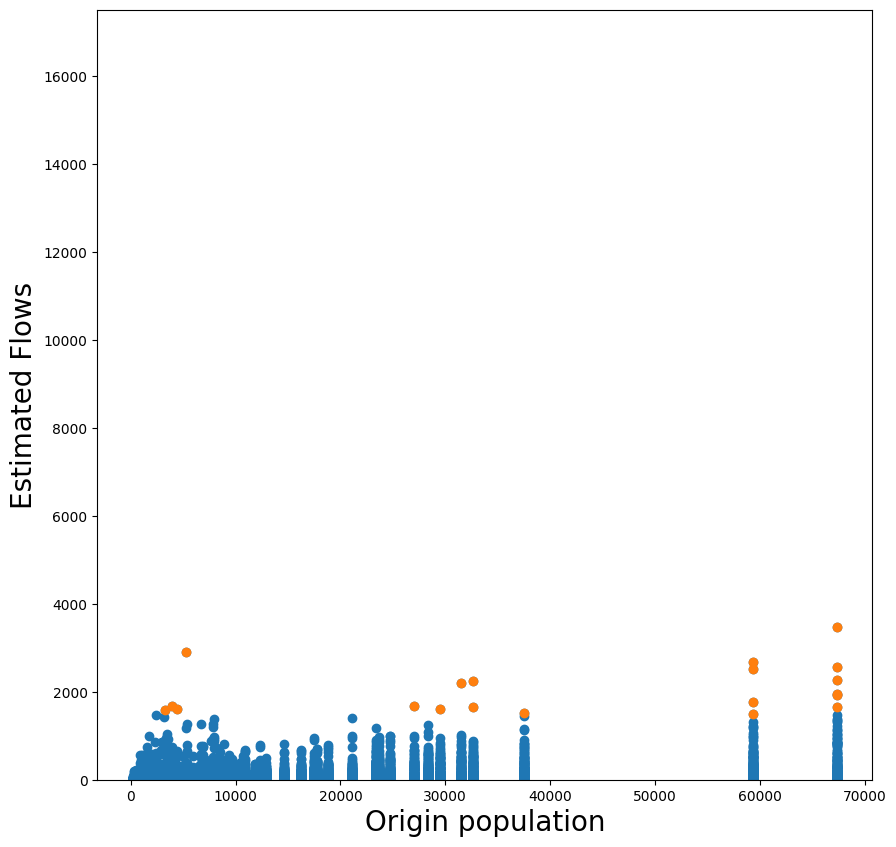

In [103]:
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = canary_half_sorted["population"], y=canary_half_sorted["prodsimest_canary_wharf"])
ax.scatter(x = canary_half_top10["population"], y=canary_half_top10["prodsimest_canary_wharf"])

plt.ylim(0, 17500)

ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Estimated Flows", fontsize = 20)

Text(0, 0.5, 'Estimated flows')

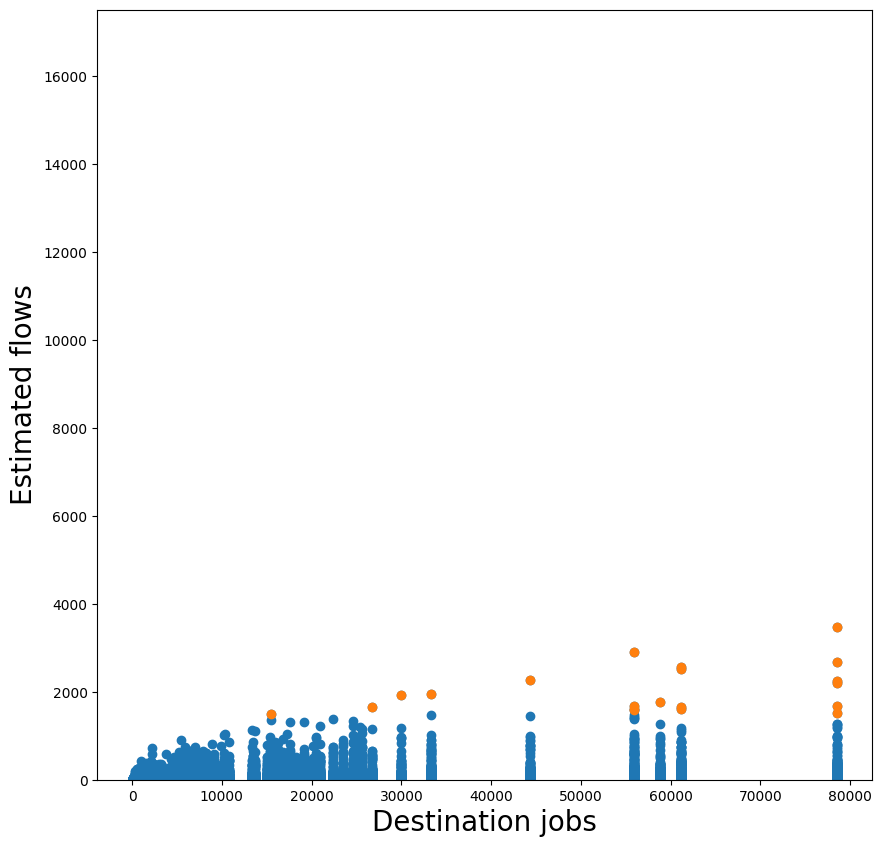

In [187]:
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = canary_half_sorted["jobs"], y=canary_half_sorted["prodsimest_canary_wharf"])
ax.scatter(x = canary_half_top10["jobs"], y=canary_half_top10["prodsimest_canary_wharf"])

plt.ylim(0, 17500)


ax.set_xlabel("Destination jobs", fontsize = 20)
ax.set_ylabel("Estimated flows", fontsize = 20)

Text(0, 0.5, 'Estimated Flows')

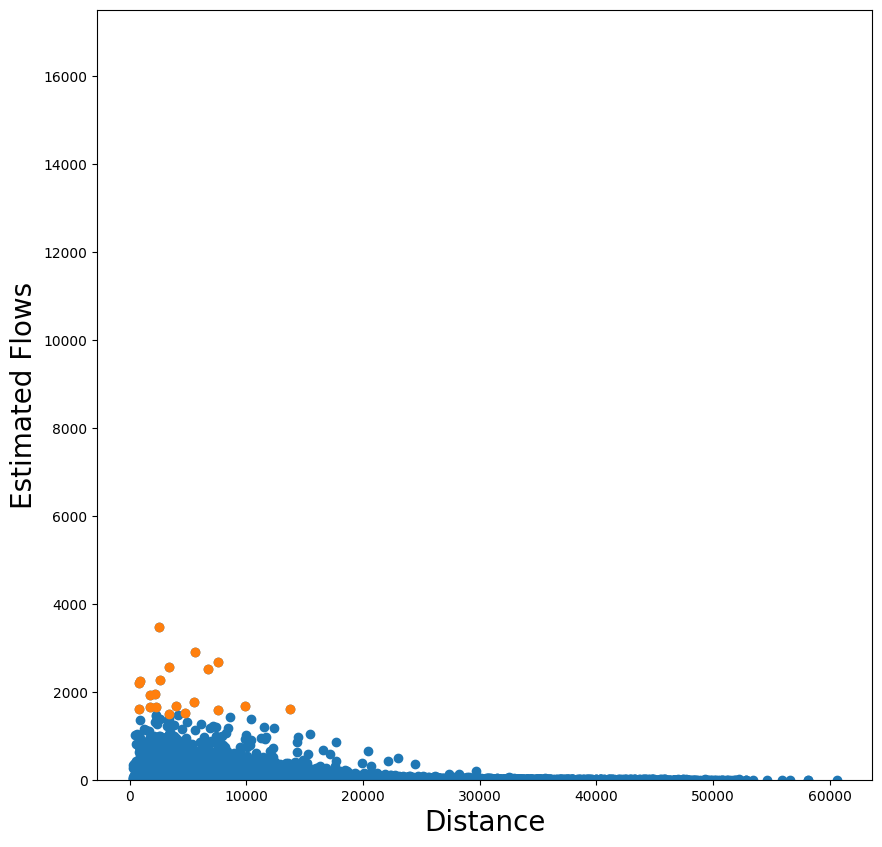

In [105]:
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = canary_half_sorted["distance"], y=canary_half_sorted["prodsimest_canary_wharf"])
ax.scatter(x = canary_half_top10["distance"], y=canary_half_top10["prodsimest_canary_wharf"])

plt.ylim(0, 17500)

ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Estimated Flows", fontsize = 20)

In [ ]:
canary_only = canary_half[(canary_half['station_destination'] == 'Canary Wharf')]
canary_only.sort_values(by = 'prodsimest_canary_wharf', ascending= False).head(20)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
35627,Stratford,Canary Wharf,3875,59311,58772,5482.674320,10.990550,8.609348,10.981421,59311,58772,0.776616,6270.986255,29386.0,794.179893,0.000037,1760.118355,-2114.881645
22418,Lewisham,Canary Wharf,1920,7868,58772,6126.937274,8.970559,8.720450,10.981421,7868,58772,0.460848,4572.913067,29386.0,723.939745,0.000223,1268.713194,-651.286806
6193,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,10.204555,7.863984,10.981421,27026,58772,-0.208187,2342.546800,29386.0,1201.561380,0.000031,999.316009,-3030.683991
6697,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,9.958212,7.957734,10.981421,21125,58772,-0.230186,2291.544350,29386.0,1158.198494,0.000039,947.014935,-310.985065
43915,Woolwich Arsenal,Canary Wharf,82,7892,58772,9863.964667,8.973605,9.196643,10.981421,7892,58772,0.711189,5873.337665,29386.0,423.085405,0.000278,927.777653,845.777653
40121,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,8.913817,10.981421,67314,58772,0.331303,4017.168451,29386.0,599.947520,0.000021,842.430955,-7242.569045
22903,Limehouse,Canary Wharf,627,5348,58772,1877.817231,8.584478,7.537865,10.981421,5310,58772,-0.615350,1559.120347,29386.0,1333.346025,0.000112,790.748066,163.748066
25876,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,9.299358,7.511953,10.981421,10931,58772,-0.741401,1374.478641,29386.0,1342.583379,0.000045,665.107414,-950.892586
31975,Shadwell,Canary Wharf,596,6741,58772,3070.320964,8.815964,8.029537,10.981421,6740,58772,-0.749850,1362.813206,29386.0,1123.320993,0.000074,559.492530,-36.507470
23255,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,8.644567,10.981421,32593,58772,-0.350635,2031.304575,29386.0,772.059314,0.000022,549.709472,-5615.290528


In [ ]:
canary_only = canary_half[(canary_half['station_destination'] == 'Canary Wharf')]
canary_only.sort_values(by = 'flows_diff', ascending= True).head(20)


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
40121,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,8.913817,10.981421,67314,58772,0.331303,4017.168451,29386.0,599.947520,0.000021,842.430955,-7242.569045
23255,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,8.644567,10.981421,32593,58772,-0.350635,2031.304575,29386.0,772.059314,0.000022,549.709472,-5615.290528
6193,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,10.204555,7.863984,10.981421,27026,58772,-0.208187,2342.546800,29386.0,1201.561380,0.000031,999.316009,-3030.683991
35627,Stratford,Canary Wharf,3875,59311,58772,5482.674320,10.990550,8.609348,10.981421,59311,58772,0.776616,6270.986255,29386.0,794.179893,0.000037,1760.118355,-2114.881645
1871,Bank and Monument,Canary Wharf,2339,29494,58772,5387.422428,10.291942,8.591822,10.981421,29494,58772,-0.507227,1736.885120,29386.0,805.127653,0.000021,490.083404,-1848.916596
34170,Southwark,Canary Wharf,1429,4882,58772,6777.558821,8.493310,8.821372,10.981421,4882,58772,-2.189321,323.022622,29386.0,659.309046,0.000023,74.575088,-1354.424912
25876,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,9.299358,7.511953,10.981421,10931,58772,-0.741401,1374.478641,29386.0,1342.583379,0.000045,665.107414,-950.892586
3205,Bermondsey,Canary Wharf,937,5102,58772,3591.383197,8.537388,8.186293,10.981421,5102,58772,-1.940806,414.191478,29386.0,1042.264386,0.000029,152.582209,-784.417791
22418,Lewisham,Canary Wharf,1920,7868,58772,6126.937274,8.970559,8.720450,10.981421,7868,58772,0.460848,4572.913067,29386.0,723.939745,0.000223,1268.713194,-651.286806
1497,Baker Street,Canary Wharf,687,7444,58772,11342.536819,8.915164,9.336315,10.981421,7444,58772,-1.740397,506.018080,29386.0,342.083368,0.000024,60.336772,-626.663228


In [ ]:
canary_only = canary_half[(canary_half['station_destination'] == 'Canary Wharf')]
canary_only.sort_values(by = 'flows_diff', ascending= False)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
43915,Woolwich Arsenal,Canary Wharf,82,7892,58772,9863.964667,8.973605,9.196643,10.981421,7892,58772,0.711189,5873.337665,29386.0,423.085405,0.000278,927.777653,845.777653
22978,Liverpool Street,Canary Wharf,24,31473,58772,6093.864865,10.356885,8.715038,10.981421,31473,58772,-0.369645,1993.034469,29386.0,727.389254,0.000022,507.912852,483.912852
42177,Westferry,Canary Wharf,25,2205,58772,904.200224,7.698483,6.807051,10.981421,2205,58772,-1.569294,600.665900,29386.0,1533.622325,0.000104,352.665811,327.665811
29327,Poplar,Canary Wharf,55,2271,58772,588.106790,7.727976,6.376909,10.981421,2271,58772,-1.566971,602.099877,29386.0,1604.906537,0.000102,370.630331,315.630331
17829,Heron Quays,Canary Wharf,34,1788,58772,351.571987,7.488853,5.862414,10.981421,1788,58772,-1.681213,537.137902,29386.0,1660.408034,0.000117,348.451607,314.451607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,Bank and Monument,Canary Wharf,2339,29494,58772,5387.422428,10.291942,8.591822,10.981421,29494,58772,-0.507227,1736.885120,29386.0,805.127653,0.000021,490.083404,-1848.916596
35627,Stratford,Canary Wharf,3875,59311,58772,5482.674320,10.990550,8.609348,10.981421,59311,58772,0.776616,6270.986255,29386.0,794.179893,0.000037,1760.118355,-2114.881645
6193,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,10.204555,7.863984,10.981421,27026,58772,-0.208187,2342.546800,29386.0,1201.561380,0.000031,999.316009,-3030.683991
23255,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,8.644567,10.981421,32593,58772,-0.350635,2031.304575,29386.0,772.059314,0.000022,549.709472,-5615.290528


In [164]:
canary_half['prodsimest_canary_wharf'].mean()


35.095756058709746

In [165]:
canary_half['prodsimest_canary_wharf'].median()


11.47765472882974

In [166]:
canary_half['prodsimest_canary_wharf'].min()


0.0027064852385211406

In [183]:
canary_half['prodsimest_canary_wharf'].max()

3472.8276635945426

In [185]:
canary_half

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,9.049012,6.091310,599,442,-2.491868,6.867445,442.0,24.453557,0.000150,2.189909,1.189909
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,8.236275,6.499787,599,665,-2.491868,9.237831,665.0,64.955507,0.000150,5.817013,2.817013
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348,10.981421,599,58772,-2.491868,238.702047,29386.0,840.713784,0.000150,75.289124,74.289124
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,7.709274,9.643939,599,15428,-2.491868,90.453395,15428.0,794.284029,0.000150,71.131162,34.131162
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,8.807842,7.096721,599,1208,-2.491868,14.244502,1208.0,65.919741,0.000150,5.903364,4.903364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,9.503144,8.114325,7892,3342,0.711189,733.420529,3342.0,52.542151,0.000278,115.218897,-11.781103
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,9.071245,8.610137,7892,5487,0.711189,1051.056725,5487.0,147.965600,0.000278,324.471550,-283.528450
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,9.162905,5.991465,7892,400,0.711189,157.178754,400.0,19.624329,0.000278,43.033898,37.033898
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,8.585832,6.794587,7892,893,0.711189,281.526349,893.0,64.106445,0.000278,140.578063,59.578063


In [184]:
rows_with_zero_flow = canary_half[canary_half['prodsimest_canary_wharf'] == 0]

print(rows_with_zero_flow)

Empty DataFrame
Columns: [station_origin, station_destination, flows, population, jobs, distance, log_population, log_distance, log_jobs, O_i2, D_j2, alpha_i1, prodsimest1_org, jobs_reduction, Ai1, A_i, prodsimest_canary_wharf, flows_diff]
Index: []


In [186]:
canary_half.tail()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_distance,log_jobs,O_i2,D_j2,alpha_i1,prodsimest1_org,jobs_reduction,Ai1,A_i,prodsimest_canary_wharf,flows_diff
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,9.503144,8.114325,7892,3342,0.711189,733.420529,3342.0,52.542151,0.000278,115.218897,-11.781103
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,9.071245,8.610137,7892,5487,0.711189,1051.056725,5487.0,147.965600,0.000278,324.471550,-283.528450
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,9.162905,5.991465,7892,400,0.711189,157.178754,400.0,19.624329,0.000278,43.033898,37.033898
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,8.585832,6.794587,7892,893,0.711189,281.526349,893.0,64.106445,0.000278,140.578063,59.578063
43944,Woolwich Arsenal,Westferry,76,7892,1250,9958.371322,8.973605,9.206169,7.130899,7892,1250,0.711189,359.304755,1250.0,42.222716,0.000278,92.589562,16.589562


### Scenario B



In [106]:
costs_org = pd.read_csv("london_flows_latest.csv")

In [107]:
costs_org = costs_org[costs_org['flows']!= 0]
coscosts_orgts_5x = costs_org[costs_org['distance'] != 0]
costs_org = costs_org[(costs_org['station_origin'] != 'Battersea Park') & (costs_org['station_destination'] != 'Battersea Park')]

In [108]:
costs_org

,station_origin,station_destination,flows,population,jobs,distance
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [109]:
doubsim_costs = "flows ~ station_origin + station_destination + distance -1"
doubsim_costs = smf.glm(formula=doubsim_costs, data = costs_org, family = sm.families.Poisson()).fit()
print(doubsim_costs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43952
Model:                            GLM   Df Residuals:                    43156
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.6664e+05
Date:                Mon, 22 Apr 2024   Deviance:                   1.3611e+06
Time:                        13:04:56   Pearson chi2:                 1.75e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [110]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i3 = pd.DataFrame(costs_org.groupby(["station_origin"])["flows"].agg(np.sum))
O_i3.rename(columns={"flows":"O_i3"}, inplace = True)
costs_org = costs_org.merge(O_i3, on = "station_origin", how = "left" )

D_j3 = pd.DataFrame(costs_org.groupby(["station_destination"])["flows"].agg(np.sum))
D_j3.rename(columns={"flows":"D_j3"}, inplace = True)
costs_org = costs_org.merge(D_j3, on = "station_destination", how = "left" )

In [111]:
costs_org

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3
0,Abbey Road,Beckton,1,599,442,8510.121774,599,442
1,Abbey Road,Blackwall,3,599,665,3775.448872,599,665
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772
3,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208
...,...,...,...,...,...,...,...,...
43947,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342
43948,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487
43949,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400
43950,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893


In [121]:

# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [113]:
# Use the beta we got from the negative exponential model
beta_org = -doubsim_costs.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
costs_org = balance_doubly_constrained(costs_org,'station_origin','station_destination','O_i3','D_j3','distance',-beta_org,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
costs_org['SIM_est_exp'] = np.round(costs_org['O_i3'] * costs_org['Ai_exp'] * costs_org['D_j3'] * costs_org['Bj_exp'] * 
                                   np.exp(costs_org['distance']*-beta_org))


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24


In [120]:
costs_org

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp
0,Abbey Road,Beckton,1,599,442,8510.121774,599,442,0.100910,0.125943,4.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,0.100910,4.667803,4.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,0.100910,68.997384,128.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,0.100910,0.128349,54.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208,0.100910,5.472457,6.0
...,...,...,...,...,...,...,...,...,...,...,...
43947,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,74063.896786,34798.832926,185.0
43948,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,74063.896786,0.001897,214.0
43949,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,74063.896786,3.917397,27.0
43950,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,74063.896786,0.007435,132.0


Costs increases by 20 times.

In [125]:
beta_20x = -doubsim_costs.params[-1] * 20
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
costs_20x = balance_doubly_constrained(costs_org,'station_origin','station_destination','O_i3','D_j3','distance',-beta_20x,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
costs_20x['SIM_est_exp_costs_20x'] = np.round(costs_20x['O_i3'] * costs_20x['Ai_exp'] * costs_20x['D_j3'] * costs_20x['Bj_exp'] * 
                                   np.exp(costs_20x['distance']*-beta_20x))


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [126]:
costs_20x

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x
0,Abbey Road,Beckton,1,599,442,8510.121774,599,442,0.100910,0.125943,4.0,0.0,0.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,0.100910,4.667803,4.0,4.0,4.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,0.100910,68.997384,128.0,106.0,106.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,0.100910,0.128349,54.0,195.0,195.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208,0.100910,5.472457,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43947,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,74063.896786,34798.832926,185.0,1.0,1.0
43948,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,74063.896786,0.001897,214.0,0.0,0.0
43949,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,74063.896786,3.917397,27.0,1.0,1.0
43950,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,74063.896786,0.007435,132.0,774.0,774.0


In [128]:
costs_20x['flows_diff_20x'] = costs_20x['SIM_est_exp_costs_20x'] - costs_20x['flows'] 
costs_20x = costs_20x[costs_20x['station_origin'] != costs_20x['station_destination']]
costs_20x.sort_values(by = 'flows_diff_20x', ascending = False).head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x
23233,London Bridge,Bank and Monument,445,32597,78549,886.728371,32597,78549,1.629468e-09,48618.067496,2688.0,15768.0,15768.0,15323.0
39208,Victoria,Green Park,1989,37517,26754,1209.599809,37517,26754,1.346244e-08,40449.773454,1182.0,16762.0,16762.0,14773.0
6698,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,21125,58772,6.247410e-04,68.997384,1916.0,14235.0,14235.0,12977.0
22952,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,1.054537e-09,48618.067496,2754.0,11224.0,11224.0,10412.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,5.344008e-02,20902.150189,2334.0,16862.0,16862.0,9916.0
25880,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,10931,58772,4.791939e-05,68.997384,1470.0,10912.0,10912.0,9296.0
39100,Vauxhall,Victoria,829,16218,33251,2225.206404,16218,33251,2.032695e-06,5564.327873,786.0,10030.0,10030.0,9201.0
39322,Victoria,St. James's Park,202,37517,13339,777.305596,37517,13339,1.346244e-08,12261.210072,660.0,8801.0,8801.0,8599.0
23101,Liverpool Street,Moorgate,172,31473,24574,434.087449,31473,24574,1.054537e-09,36318.843944,1039.0,8482.0,8482.0,8310.0
35895,Stratford,Whitechapel,765,59311,17633,4914.437953,59311,17633,5.344008e-02,228.357667,985.0,9067.0,9067.0,8302.0


In [129]:
costs_20x_flows_sorted = costs_20x.sort_values(by = 'SIM_est_exp_costs_20x', ascending = False)
costs_20x_flows_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,5.344008e-02,20902.150189,2334.0,16862.0,16862.0,9916.0
39208,Victoria,Green Park,1989,37517,26754,1209.599809,37517,26754,1.346244e-08,40449.773454,1182.0,16762.0,16762.0,14773.0
23233,London Bridge,Bank and Monument,445,32597,78549,886.728371,32597,78549,1.629468e-09,48618.067496,2688.0,15768.0,15768.0,15323.0
6698,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,21125,58772,6.247410e-04,68.997384,1916.0,14235.0,14235.0,12977.0
22952,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,1.054537e-09,48618.067496,2754.0,11224.0,11224.0,10412.0
25880,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,10931,58772,4.791939e-05,68.997384,1470.0,10912.0,10912.0,9296.0
39100,Vauxhall,Victoria,829,16218,33251,2225.206404,16218,33251,2.032695e-06,5564.327873,786.0,10030.0,10030.0,9201.0
35895,Stratford,Whitechapel,765,59311,17633,4914.437953,59311,17633,5.344008e-02,228.357667,985.0,9067.0,9067.0,8302.0
39322,Victoria,St. James's Park,202,37517,13339,777.305596,37517,13339,1.346244e-08,12261.210072,660.0,8801.0,8801.0,8599.0
23101,Liverpool Street,Moorgate,172,31473,24574,434.087449,31473,24574,1.054537e-09,36318.843944,1039.0,8482.0,8482.0,8310.0


In [130]:
costs_20x_flows_sorted = costs_20x_flows_sorted[costs_20x_flows_sorted['station_origin'] != costs_20x_flows_sorted['station_destination']]
costs_20x_top10 = costs_20x_flows_sorted.head(20)
costs_20x_top10

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,5.344008e-02,20902.150189,2334.0,16862.0,16862.0,9916.0
39208,Victoria,Green Park,1989,37517,26754,1209.599809,37517,26754,1.346244e-08,40449.773454,1182.0,16762.0,16762.0,14773.0
23233,London Bridge,Bank and Monument,445,32597,78549,886.728371,32597,78549,1.629468e-09,48618.067496,2688.0,15768.0,15768.0,15323.0
6698,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,21125,58772,6.247410e-04,68.997384,1916.0,14235.0,14235.0,12977.0
22952,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,1.054537e-09,48618.067496,2754.0,11224.0,11224.0,10412.0
25880,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,10931,58772,4.791939e-05,68.997384,1470.0,10912.0,10912.0,9296.0
39100,Vauxhall,Victoria,829,16218,33251,2225.206404,16218,33251,2.032695e-06,5564.327873,786.0,10030.0,10030.0,9201.0
35895,Stratford,Whitechapel,765,59311,17633,4914.437953,59311,17633,5.344008e-02,228.357667,985.0,9067.0,9067.0,8302.0
39322,Victoria,St. James's Park,202,37517,13339,777.305596,37517,13339,1.346244e-08,12261.210072,660.0,8801.0,8801.0,8599.0
23101,Liverpool Street,Moorgate,172,31473,24574,434.087449,31473,24574,1.054537e-09,36318.843944,1039.0,8482.0,8482.0,8310.0


Text(0, 0.5, 'Estimated Flows')

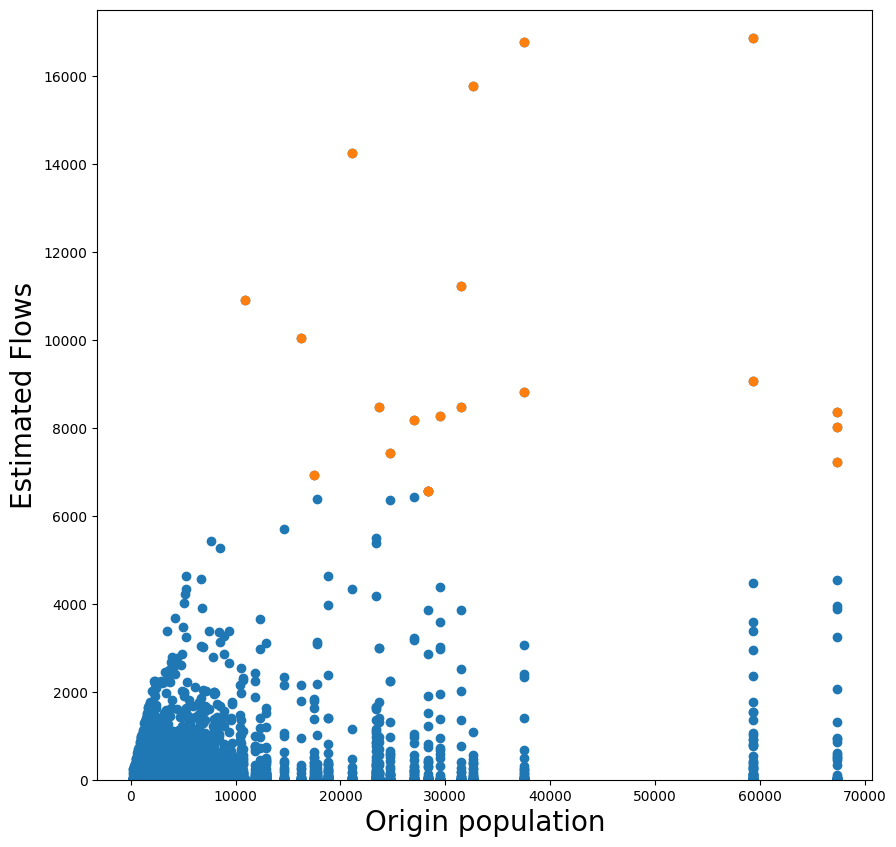

In [131]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_20x_flows_sorted["population"], y=costs_20x_flows_sorted["SIM_est_exp_costs_20x"])
ax.scatter(x = costs_20x_top10["population"], y=costs_20x_top10["SIM_est_exp_costs_20x"])

plt.ylim(0, 17500)

ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Estimated Flows", fontsize = 20)

Text(0, 0.5, 'Estimated flows')

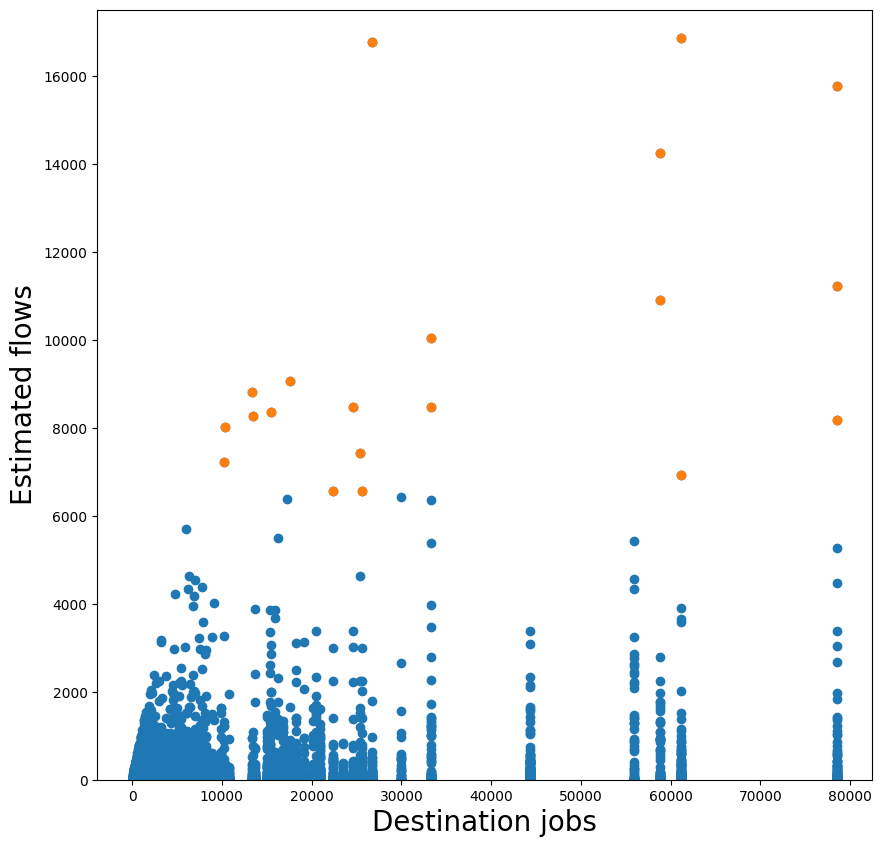

In [133]:
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_20x_flows_sorted["jobs"], y=costs_20x_flows_sorted["SIM_est_exp_costs_20x"])
ax.scatter(x = costs_20x_top10["jobs"], y=costs_20x_top10["SIM_est_exp_costs_20x"])

plt.ylim(0, 17500)

ax.set_xlabel("Destination jobs", fontsize = 20)
ax.set_ylabel("Estimated flows", fontsize = 20)

Text(0, 0.5, 'Estimated Flows')

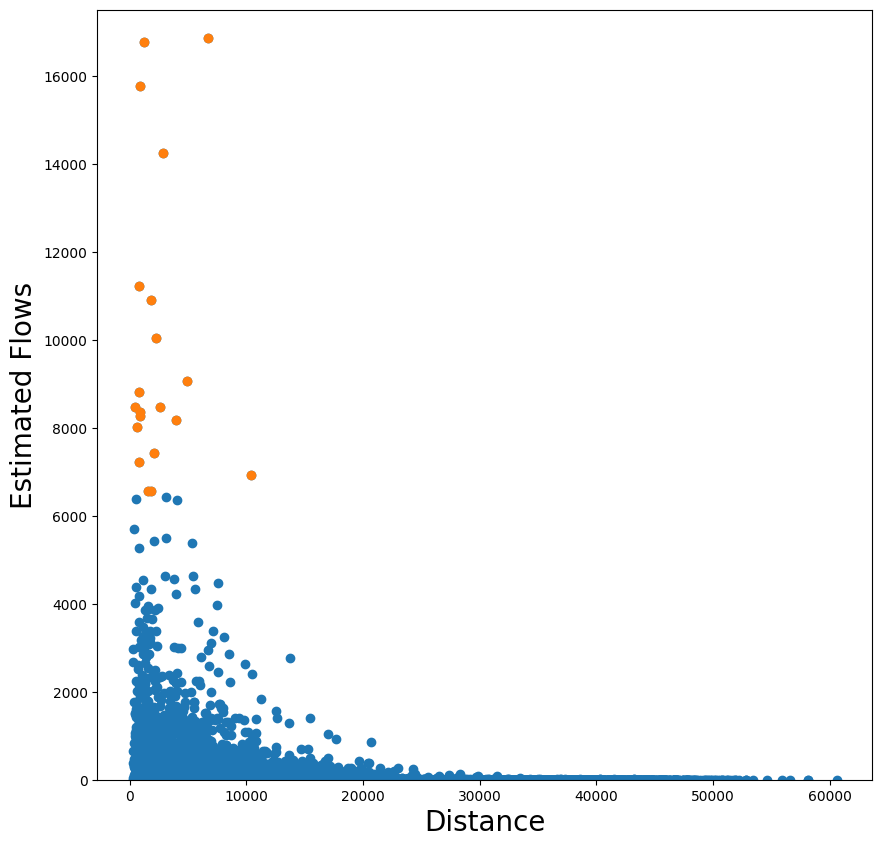

In [134]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_20x_flows_sorted["distance"], y=costs_20x_flows_sorted["SIM_est_exp_costs_20x"])
ax.scatter(x = costs_20x_top10["distance"], y=costs_20x_top10["SIM_est_exp_costs_20x"])

plt.ylim(0, 17500)

ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Estimated Flows", fontsize = 20)

In [168]:
costs_20x['SIM_est_exp_costs_20x'].mean()

33.87472977585618

In [169]:
costs_20x['SIM_est_exp_costs_20x'].median()

0.0

In [170]:
costs_20x['SIM_est_exp_costs_20x'].min()

0.0

In [171]:
costs_20x['SIM_est_exp_costs_20x'].max()

16862.0

In [190]:
rows_with_zero_flow = costs_20x[costs_20x['SIM_est_exp_costs_20x'] == 0]

print(rows_with_zero_flow)

         station_origin      station_destination  flows  population   jobs  \
0            Abbey Road                  Beckton      1         599    442   
4            Abbey Road             Crossharbour      1         599   1208   
5            Abbey Road               Cutty Sark      2         599   1748   
6            Abbey Road                   Cyprus      7         599    850   
7            Abbey Road              Devons Road      1         599    611   
...                 ...                      ...    ...         ...    ...   
43939  Woolwich Arsenal             Royal Albert     29        7892    684   
43944  Woolwich Arsenal                Stratford   1642        7892  55954   
43945  Woolwich Arsenal    Stratford High Street    255        7892    788   
43946  Woolwich Arsenal  Stratford International    314        7892   1546   
43948  Woolwich Arsenal                 West Ham    608        7892   5487   

           distance  O_i3   D_j3        Ai_exp    Bj_exp  SIM_e

Costs increases by 2 times.

In [135]:
beta_2x = -doubsim_costs.params[-1] * 2
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
costs_2x = balance_doubly_constrained(costs_org,'station_origin','station_destination','O_i3','D_j3','distance',-beta_2x,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
costs_2x['SIM_est_exp_costs_2x'] = np.round(costs_2x['O_i3'] * costs_2x['Ai_exp'] * costs_2x['D_j3'] * costs_2x['Bj_exp'] * 
                                   np.exp(costs_2x['distance']*-beta_2x))

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45


In [136]:
costs_2x

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x
0,Abbey Road,Beckton,1,599,442,8510.121774,599,442,0.000017,8.532454,4.0,3.0,0.0,-1.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,0.000017,1.571914,4.0,4.0,4.0,1.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,0.000017,0.916583,128.0,124.0,106.0,105.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,0.000017,0.820675,54.0,66.0,195.0,158.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208,0.000017,1.976625,6.0,3.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43947,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,0.000068,3.304927,185.0,124.0,1.0,-126.0
43948,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,0.000068,0.779334,214.0,187.0,0.0,-608.0
43949,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,0.000068,1.581128,27.0,22.0,1.0,-5.0
43950,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,0.000068,1.819108,132.0,186.0,774.0,693.0


In [137]:
costs_2x['flows_diff_2x'] = costs_2x['SIM_est_exp_costs_2x'] - costs_20x['flows'] 
costs_2x.sort_values(by = 'flows_diff_2x', ascending = False)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
23233,London Bridge,Bank and Monument,445,32597,78549,886.728371,32597,78549,0.000003,0.779748,2688.0,4065.0,15768.0,15323.0,3620.0
22952,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,0.000003,0.779748,2754.0,4415.0,11224.0,10412.0,3603.0
40316,Waterloo,Victoria,285,67372,33251,2188.414963,67372,33251,0.000003,0.967013,2245.0,2970.0,115.0,-170.0,2685.0
6169,Canada Water,Bank and Monument,117,27026,78549,3964.071830,27026,78549,0.000005,0.779748,1919.0,2646.0,8181.0,8064.0,2529.0
6698,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,21125,58772,0.000007,0.916583,1916.0,3524.0,14235.0,12977.0,2266.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22922,Limehouse,Limehouse,38,5348,2969,0.000000,5348,2969,0.000009,1.926451,206.0,290.0,2134.0,2096.0,NaN
23352,London Bridge,London Bridge,4,32597,29930,0.000000,32597,29930,0.000003,0.837750,1303.0,2149.0,12398.0,12394.0,NaN
28150,Paddington,Paddington,5,23381,20198,0.000000,23381,20198,0.000004,1.066522,908.0,2092.0,12905.0,12900.0,NaN
32028,Shadwell,Shadwell,1,6741,7447,0.000000,6741,7447,0.000007,1.076351,234.0,362.0,1588.0,1587.0,NaN


Sort by estimated flows.

In [138]:
costs_2x_flows_sorted = costs_2x.sort_values(by = 'SIM_est_exp_costs_2x', ascending = False)
costs_2x_flows_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
35633,Stratford,Canary Wharf,3875,59311,58772,5482.674320,59311,58772,0.000008,0.916583,3650.0,5347.0,1777.0,-2098.0,1472.0
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,5108.0,852.0,-15094.0,-10838.0
22952,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,0.000003,0.779748,2754.0,4415.0,11224.0,10412.0,3603.0
23233,London Bridge,Bank and Monument,445,32597,78549,886.728371,32597,78549,0.000003,0.779748,2688.0,4065.0,15768.0,15323.0,3620.0
20020,Ilford,Stratford,3080,5298,55954,5635.299025,5298,55954,0.000134,0.499204,3181.0,3903.0,4345.0,1265.0,823.0
6698,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,21125,58772,0.000007,0.916583,1916.0,3524.0,14235.0,12977.0,2266.0
6194,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,27026,58772,0.000005,0.916583,2150.0,3446.0,440.0,-3590.0,-584.0
35603,Stratford,Bank and Monument,1138,59311,78549,7539.963954,59311,78549,0.000008,0.779748,2947.0,3361.0,4463.0,3325.0,2223.0
40321,Waterloo,Waterloo,58,67372,23466,0.000000,67372,23466,0.000003,0.802798,1964.0,3269.0,18610.0,18552.0,NaN
25880,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,10931,58772,0.000009,0.916583,1470.0,3234.0,10912.0,9296.0,1618.0


In [139]:
costs_2x_flows_sorted = costs_2x_flows_sorted[costs_2x_flows_sorted['station_origin'] != costs_2x_flows_sorted['station_destination']]
costs_2x_flows_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
35633,Stratford,Canary Wharf,3875,59311,58772,5482.674320,59311,58772,0.000008,0.916583,3650.0,5347.0,1777.0,-2098.0,1472.0
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,5108.0,852.0,-15094.0,-10838.0
22952,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,0.000003,0.779748,2754.0,4415.0,11224.0,10412.0,3603.0
23233,London Bridge,Bank and Monument,445,32597,78549,886.728371,32597,78549,0.000003,0.779748,2688.0,4065.0,15768.0,15323.0,3620.0
20020,Ilford,Stratford,3080,5298,55954,5635.299025,5298,55954,0.000134,0.499204,3181.0,3903.0,4345.0,1265.0,823.0
6698,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,21125,58772,0.000007,0.916583,1916.0,3524.0,14235.0,12977.0,2266.0
6194,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,27026,58772,0.000005,0.916583,2150.0,3446.0,440.0,-3590.0,-584.0
35603,Stratford,Bank and Monument,1138,59311,78549,7539.963954,59311,78549,0.000008,0.779748,2947.0,3361.0,4463.0,3325.0,2223.0
25880,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,10931,58772,0.000009,0.916583,1470.0,3234.0,10912.0,9296.0,1618.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.000008,0.752922,2334.0,3218.0,16862.0,9916.0,-3728.0


In [140]:
costs_2x_top10 = costs_2x_flows_sorted.head(20)
costs_2x_top10

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
35633,Stratford,Canary Wharf,3875,59311,58772,5482.674320,59311,58772,0.000008,0.916583,3650.0,5347.0,1777.0,-2098.0,1472.0
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,5108.0,852.0,-15094.0,-10838.0
22952,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,0.000003,0.779748,2754.0,4415.0,11224.0,10412.0,3603.0
23233,London Bridge,Bank and Monument,445,32597,78549,886.728371,32597,78549,0.000003,0.779748,2688.0,4065.0,15768.0,15323.0,3620.0
20020,Ilford,Stratford,3080,5298,55954,5635.299025,5298,55954,0.000134,0.499204,3181.0,3903.0,4345.0,1265.0,823.0
6698,Canning Town,Canary Wharf,1258,21125,58772,2857.591052,21125,58772,0.000007,0.916583,1916.0,3524.0,14235.0,12977.0,2266.0
6194,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,27026,58772,0.000005,0.916583,2150.0,3446.0,440.0,-3590.0,-584.0
35603,Stratford,Bank and Monument,1138,59311,78549,7539.963954,59311,78549,0.000008,0.779748,2947.0,3361.0,4463.0,3325.0,2223.0
25880,North Greenwich,Canary Wharf,1616,10931,58772,1829.783291,10931,58772,0.000009,0.916583,1470.0,3234.0,10912.0,9296.0,1618.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.000008,0.752922,2334.0,3218.0,16862.0,9916.0,-3728.0


In [141]:
costs_2x_least10 = costs_2x_flows_sorted.tail(10)
costs_2x_least10

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
31111,Royal Oak,Dollis Hill,1,1409,847,10497.928848,1409,847,0.000007,1.002333,1.0,0.0,0.0,-1.0,-1.0
9608,Dagenham East,Balham,1,1924,3814,28854.243724,1924,3814,0.000146,1.428487,3.0,0.0,0.0,-1.0,-1.0
9612,Dagenham East,Barons Court,1,1924,2956,29809.622068,1924,2956,0.000146,1.344138,1.0,0.0,0.0,-1.0,-1.0
31114,Royal Oak,East Ham,1,1409,2062,19143.054874,1409,2062,0.000007,1.256449,1.0,0.0,0.0,-1.0,-1.0
19148,Homerton,Forest Hill,1,3501,608,17522.394139,3501,608,0.000023,1.443869,5.0,0.0,0.0,-1.0,-1.0
9622,Dagenham East,Buckhurst Hill,1,1924,228,24463.567459,1924,228,0.000146,0.635882,1.0,0.0,0.0,-1.0,-1.0
19142,Homerton,Crystal Palace,4,3501,499,20917.332065,3501,499,0.000023,3.773737,5.0,0.0,0.0,-4.0,-4.0
19140,Homerton,Chingford,1,3501,237,20884.417469,3501,237,0.000023,2.064229,2.0,0.0,0.0,-1.0,-1.0
9629,Dagenham East,Chalk Farm,1,1924,1329,25550.949884,1924,1329,0.000146,1.597298,1.0,0.0,0.0,-1.0,-1.0
21976,Lambeth North,Uxbridge,1,1114,4316,31534.637240,1114,4316,0.000003,1.650252,0.0,0.0,0.0,-1.0,-1.0


In [142]:
costs_2x_flows_sorted[(costs_2x_flows_sorted['SIM_est_exp_costs_2x'] == 0)]

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
512,Aldgate East,Upney,1,3172,485,13259.468620,3172,485,0.000003,1.102508,1.0,0.0,0.0,-1.0,-1.0
43524,Wood Lane,Hounslow West,4,1088,401,15612.654342,1088,401,0.000015,1.666192,1.0,0.0,0.0,-4.0,-4.0
25883,North Greenwich,Canons Park,4,10931,526,29829.405420,10931,526,0.000009,0.880947,1.0,0.0,0.0,-4.0,-4.0
28888,Pimlico,Kenton,1,3917,768,19880.219735,3917,768,0.000004,4.040290,2.0,0.0,0.0,-1.0,-1.0
40352,Watford,Barking,1,1400,7004,47696.475681,1400,7004,0.004102,1.178145,1.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9622,Dagenham East,Buckhurst Hill,1,1924,228,24463.567459,1924,228,0.000146,0.635882,1.0,0.0,0.0,-1.0,-1.0
19142,Homerton,Crystal Palace,4,3501,499,20917.332065,3501,499,0.000023,3.773737,5.0,0.0,0.0,-4.0,-4.0
19140,Homerton,Chingford,1,3501,237,20884.417469,3501,237,0.000023,2.064229,2.0,0.0,0.0,-1.0,-1.0
9629,Dagenham East,Chalk Farm,1,1924,1329,25550.949884,1924,1329,0.000146,1.597298,1.0,0.0,0.0,-1.0,-1.0


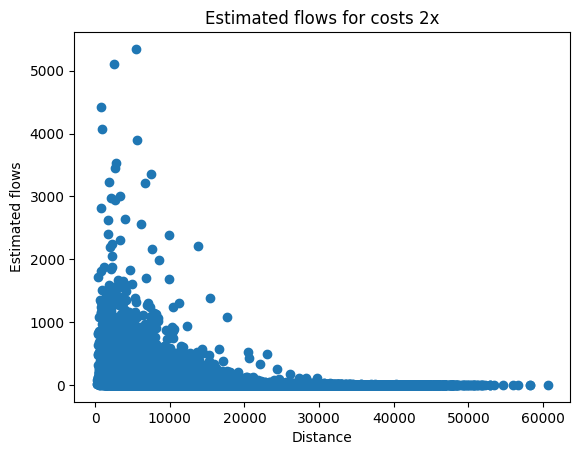

In [ ]:
plt.scatter(costs_2x_flows_sorted['distance'], costs_2x_flows_sorted['SIM_est_exp_costs_2x'])

# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Estimated flows')
plt.title('Estimated flows for costs 2x')

# Show the plot
plt.show()

Text(0, 0.5, 'Estimated Flows')

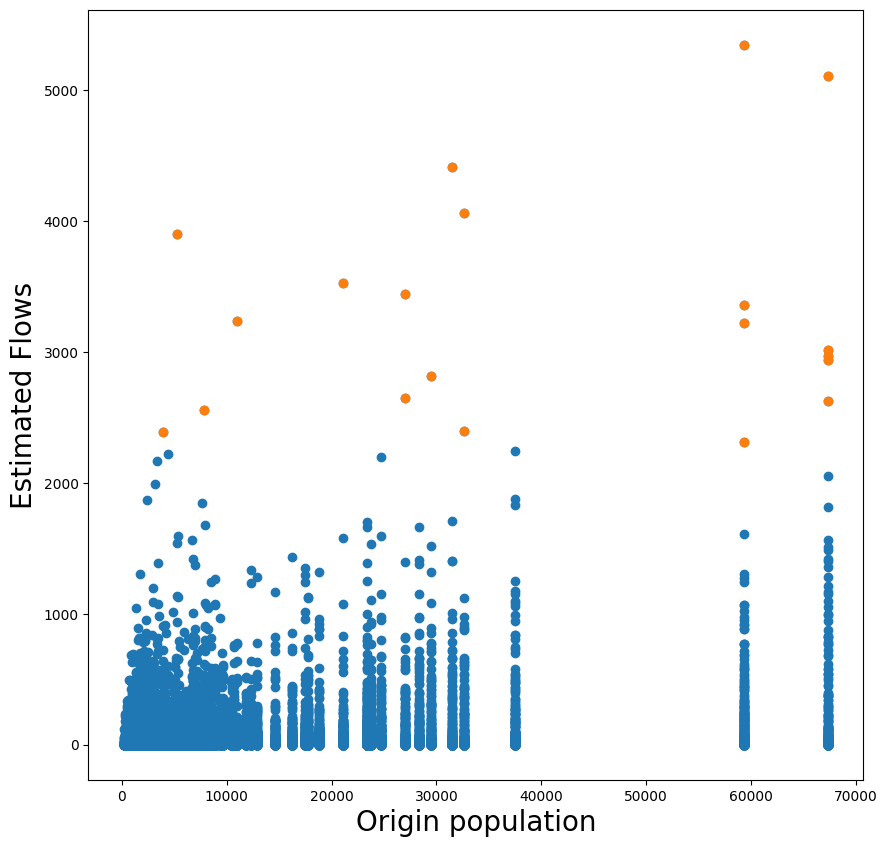

In [172]:
#Let us now look at the behaviour of the flows with respect to the population at the origin denoted by O
#and then fit a model line T ~ O^alpha, for alpha=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_2x_flows_sorted["population"], y=costs_2x_flows_sorted["SIM_est_exp_costs_2x"])
ax.scatter(x = costs_2x_top10["population"], y=costs_2x_top10["SIM_est_exp_costs_2x"])

ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Estimated Flows", fontsize = 20)

Text(0, 0.5, 'Estimated flows')

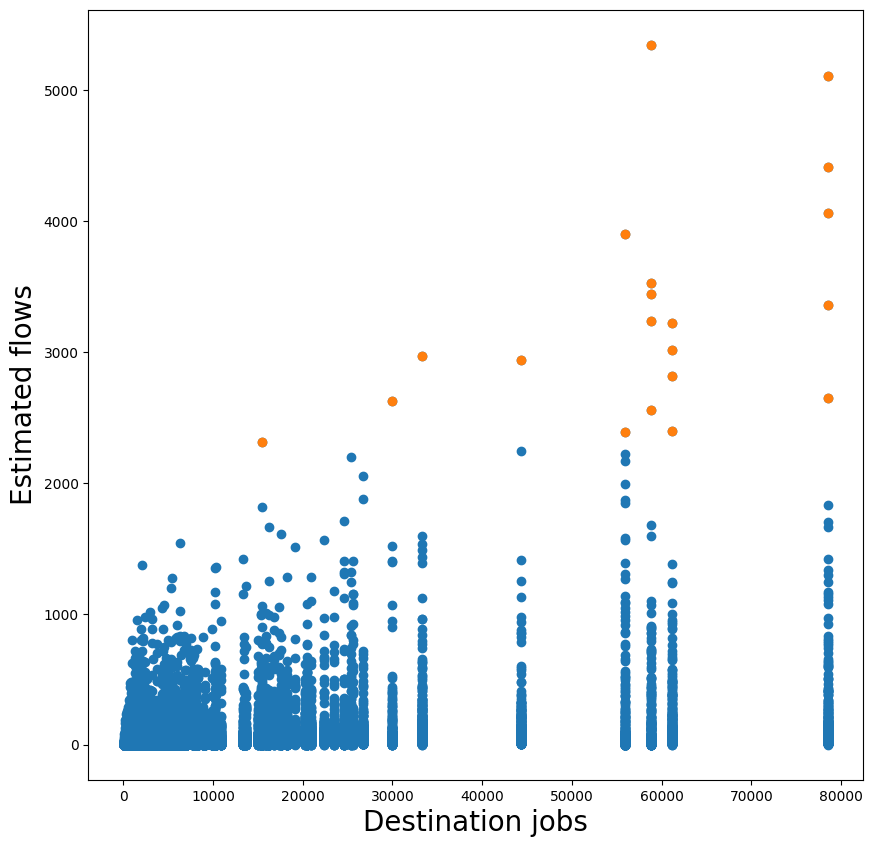

In [173]:
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_2x_flows_sorted["jobs"], y=costs_2x_flows_sorted["SIM_est_exp_costs_2x"])
ax.scatter(x = costs_2x_top10["jobs"], y=costs_2x_top10["SIM_est_exp_costs_2x"])

#plt.ylim(0, 17500)

ax.set_xlabel("Destination jobs", fontsize = 20)
ax.set_ylabel("Estimated flows", fontsize = 20)

Text(0, 0.5, 'Estimated Flows')

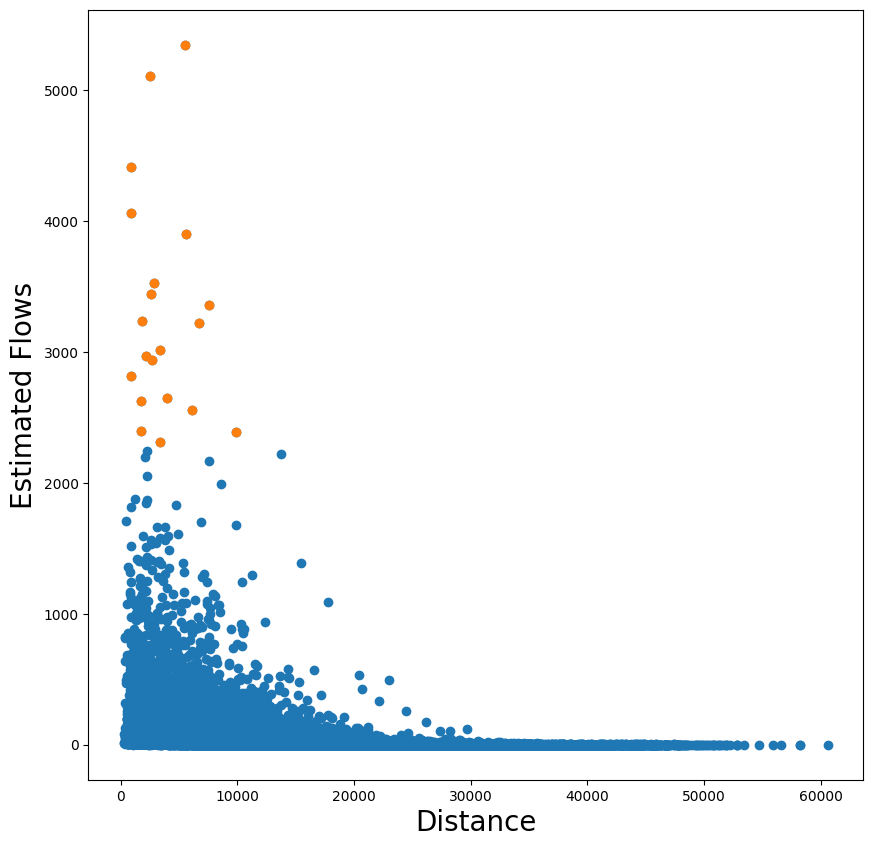

In [174]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_2x_flows_sorted["distance"], y=costs_2x_flows_sorted["SIM_est_exp_costs_2x"])
ax.scatter(x = costs_2x_top10["distance"], y=costs_2x_top10["SIM_est_exp_costs_2x"])

#plt.ylim (0, 17500)

ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Estimated Flows", fontsize = 20)

In [ ]:
costs_2x_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_10x,flows_diff_10x,SIM_est_exp_costs_2x,flows_diff_2x
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,3119.0,12827.0,5108.0,10838.0
40127,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,67372,58772,0.000003,0.916583,1925.0,0.0,8085.0,1098.0,6987.0
23258,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,32597,58772,0.000003,0.916583,1241.0,0.0,6165.0,899.0,5266.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.000008,0.752922,2334.0,10393.0,-3447.0,3218.0,3728.0
39283,Victoria,Oxford Circus,5181,37517,44368,2220.166284,37517,44368,0.000003,0.818632,1658.0,3603.0,1578.0,2241.0,2940.0
23027,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,31473,25592,0.000003,0.947559,954.0,2553.0,1202.0,1404.0,2351.0
39350,Victoria,Warren Street,2599,37517,17309,3369.880730,37517,17309,0.000003,0.914228,607.0,177.0,2422.0,701.0,1898.0
6298,Canada Water,London Bridge,3202,27026,29930,3077.343459,27026,29930,0.000005,0.837750,930.0,4922.0,-1720.0,1398.0,1804.0
5071,Brixton,Oxford Circus,2411,23381,44368,7538.965939,23381,44368,0.000009,0.818632,804.0,313.0,2098.0,825.0,1586.0
6430,Canary Wharf,Bank and Monument,2643,14632,78549,5387.422428,14632,78549,0.000006,0.779748,936.0,1061.0,1582.0,1164.0,1479.0


In [ ]:
costs_2x.to_csv('costs_increase.csv', index=False)

In [ ]:
costs_2x.sort_values(by = 'flows', ascending = False).head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_10x,flows_diff_10x,SIM_est_exp_costs_2x,flows_diff_2x
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,3119.0,-12827.0,5108.0,-10838.0
40127,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,67372,58772,0.000003,0.916583,1925.0,0.0,-8085.0,1098.0,-6987.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.000008,0.752922,2334.0,10393.0,3447.0,3218.0,-3728.0
23258,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,32597,58772,0.000003,0.916583,1241.0,0.0,-6165.0,899.0,-5266.0
39283,Victoria,Oxford Circus,5181,37517,44368,2220.166284,37517,44368,0.000003,0.818632,1658.0,3603.0,-1578.0,2241.0,-2940.0
6194,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,27026,58772,0.000005,0.916583,2150.0,1817.0,-2213.0,3446.0,-584.0
35633,Stratford,Canary Wharf,3875,59311,58772,5482.674320,59311,58772,0.000008,0.916583,3650.0,4119.0,244.0,5347.0,1472.0
23027,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,31473,25592,0.000003,0.947559,954.0,2553.0,-1202.0,1404.0,-2351.0
13901,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960,24735,25385,0.000007,0.857838,1039.0,6958.0,3299.0,2197.0,-1462.0
6298,Canada Water,London Bridge,3202,27026,29930,3077.343459,27026,29930,0.000005,0.837750,930.0,4922.0,1720.0,1398.0,-1804.0


Descriptive statistics.

In [160]:
costs_2x['SIM_est_exp_costs_2x'].mean()


35.07489989078995

In [161]:
costs_2x['SIM_est_exp_costs_2x'].median()


6.0

In [162]:
costs_2x['SIM_est_exp_costs_2x'].max()


5347.0

In [188]:
costs_2x['SIM_est_exp_costs_2x'].min()

0.0

In [189]:
rows_with_zero_flow = costs_2x[costs_2x['SIM_est_exp_costs_2x'] == 0]

print(rows_with_zero_flow)

      station_origin station_destination  flows  population  jobs  \
39     Acton Central        Hackney Wick      5        1224  1263   
52     Acton Central           New Cross      1        1224  1027   
70        Acton Town         Arnos Grove      1        3745   748   
74        Acton Town             Barking      1        3745  7004   
83        Acton Town        Bounds Green      1        3745   778   
...              ...                 ...    ...         ...   ...   
43884  Woodside Park       South Ruislip      2        3093   289   
43885  Woodside Park     South Wimbledon      4        3093  1361   
43886  Woodside Park         Southfields      1        3093  1351   
43895  Woodside Park         Tooting Bec      1        3093  1239   
43907  Woodside Park        Wembley Park      4        3093  5759   

           distance  O_i3  D_j3    Ai_exp    Bj_exp  SIM_est_exp  \
39     20677.009006  1224  1263  0.000041  1.857611          3.0   
52     22156.955782  1224  1027  0.

Original flows

In [147]:
costs_org_sorted = costs_2x.sort_values(by = 'flows', ascending = False)
costs_org_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,5108.0,852.0,-15094.0,-10838.0
40127,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,67372,58772,0.000003,0.916583,1925.0,1098.0,0.0,-8085.0,-6987.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.000008,0.752922,2334.0,3218.0,16862.0,9916.0,-3728.0
23258,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,32597,58772,0.000003,0.916583,1241.0,899.0,0.0,-6165.0,-5266.0
39283,Victoria,Oxford Circus,5181,37517,44368,2220.166284,37517,44368,0.000003,0.818632,1658.0,2241.0,2328.0,-2853.0,-2940.0
6194,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,27026,58772,0.000005,0.916583,2150.0,3446.0,440.0,-3590.0,-584.0
35633,Stratford,Canary Wharf,3875,59311,58772,5482.674320,59311,58772,0.000008,0.916583,3650.0,5347.0,1777.0,-2098.0,1472.0
23027,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,31473,25592,0.000003,0.947559,954.0,1404.0,2009.0,-1746.0,-2351.0
13901,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960,24735,25385,0.000007,0.857838,1039.0,2197.0,7416.0,3757.0,-1462.0
6298,Canada Water,London Bridge,3202,27026,29930,3077.343459,27026,29930,0.000005,0.837750,930.0,1398.0,6433.0,3231.0,-1804.0


In [148]:
costs_org_sorted = costs_org_sorted[costs_org_sorted['station_origin'] != costs_org_sorted['station_destination']]
costs_org_sorted.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,5108.0,852.0,-15094.0,-10838.0
40127,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,67372,58772,0.000003,0.916583,1925.0,1098.0,0.0,-8085.0,-6987.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.000008,0.752922,2334.0,3218.0,16862.0,9916.0,-3728.0
23258,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,32597,58772,0.000003,0.916583,1241.0,899.0,0.0,-6165.0,-5266.0
39283,Victoria,Oxford Circus,5181,37517,44368,2220.166284,37517,44368,0.000003,0.818632,1658.0,2241.0,2328.0,-2853.0,-2940.0
6194,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,27026,58772,0.000005,0.916583,2150.0,3446.0,440.0,-3590.0,-584.0
35633,Stratford,Canary Wharf,3875,59311,58772,5482.674320,59311,58772,0.000008,0.916583,3650.0,5347.0,1777.0,-2098.0,1472.0
23027,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,31473,25592,0.000003,0.947559,954.0,1404.0,2009.0,-1746.0,-2351.0
13901,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960,24735,25385,0.000007,0.857838,1039.0,2197.0,7416.0,3757.0,-1462.0
6298,Canada Water,London Bridge,3202,27026,29930,3077.343459,27026,29930,0.000005,0.837750,930.0,1398.0,6433.0,3231.0,-1804.0


In [149]:
costs_org_top20 = costs_org_sorted.head(20)

Text(0, 0.5, 'Estimated flows')

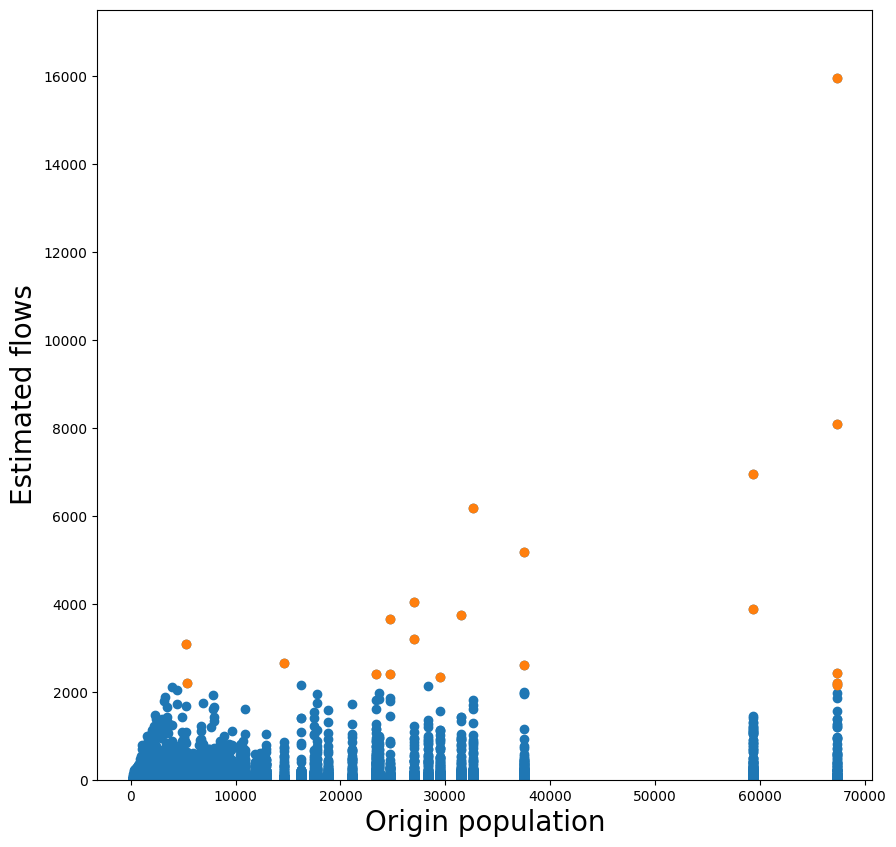

In [158]:
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_org_sorted["population"], y=costs_org_sorted["flows"])
ax.scatter(x = costs_org_top20["population"], y=costs_org_top20["flows"])

plt.ylim(0, 17500)

ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Estimated flows", fontsize = 20)

Text(0, 0.5, 'Estimated flows')

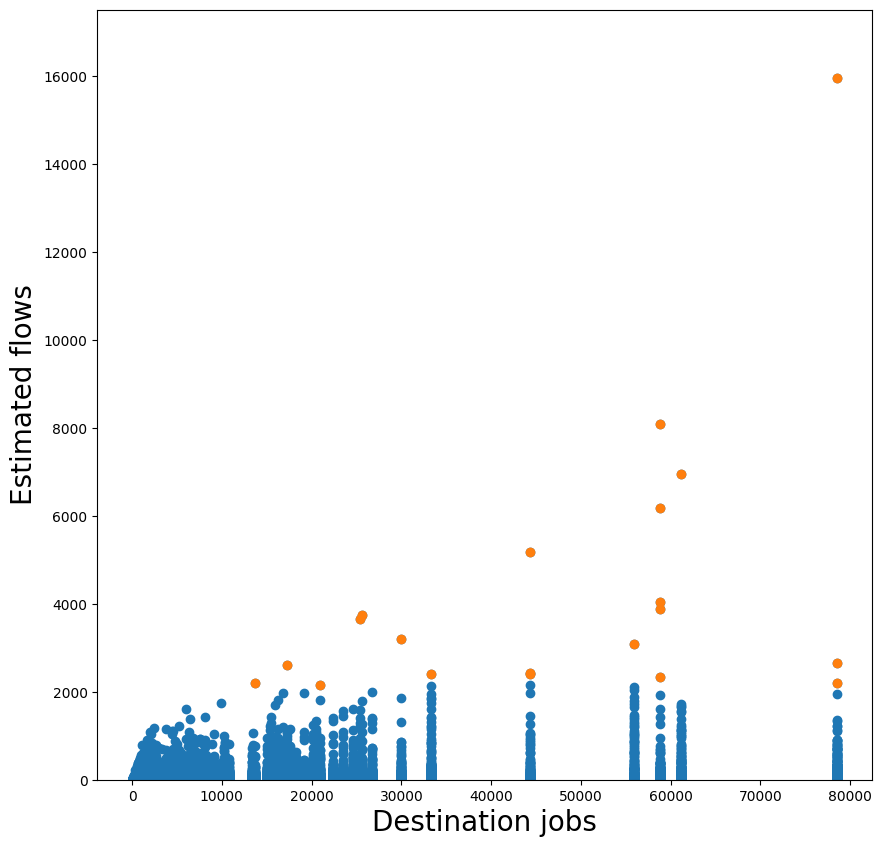

In [156]:
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_org_sorted["jobs"], y=costs_org_sorted["flows"])
ax.scatter(x = costs_org_top20["jobs"], y=costs_org_top20["flows"])

plt.ylim(0, 17500)

ax.set_xlabel("Destination jobs", fontsize = 20)
ax.set_ylabel("Estimated flows", fontsize = 20)

Text(0, 0.5, 'Estimated Flows')

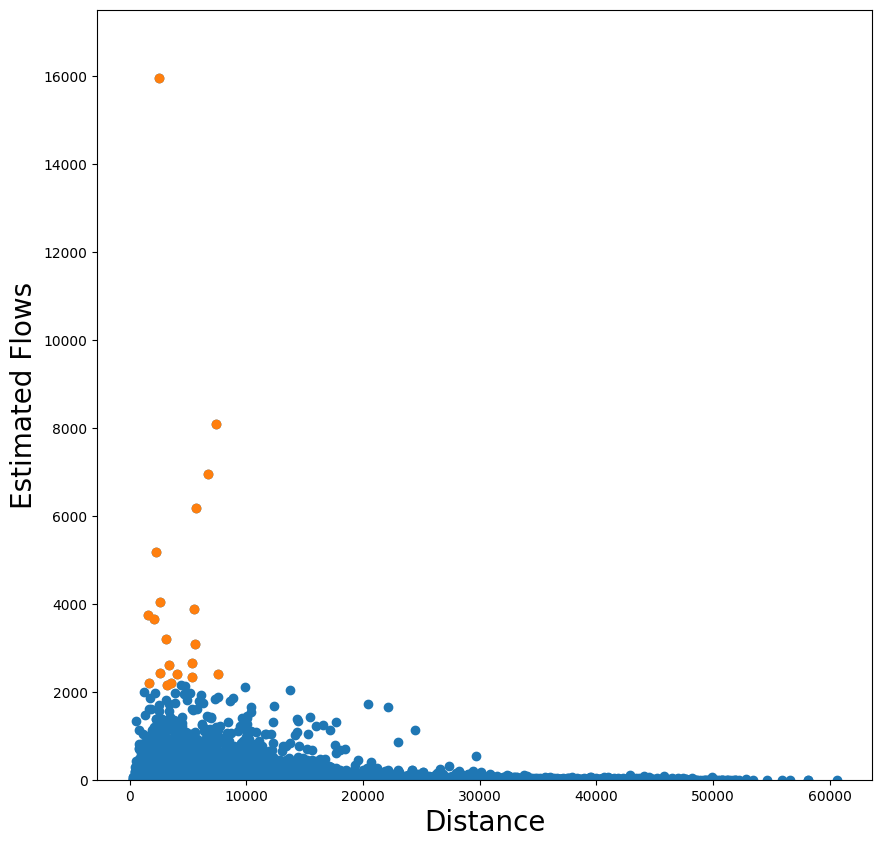

In [153]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = costs_org_sorted["distance"], y=costs_org_sorted["flows"])
ax.scatter(x = costs_org_top20["distance"], y=costs_org_top20["flows"])

plt.ylim (0, 17500)

ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Estimated Flows", fontsize = 20)

In [193]:
costs_org.sort_values(by = 'flows', ascending = False). head(20)

,station_origin,station_destination,flows,population,jobs,distance,O_i3,D_j3,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_costs_2x,SIM_est_exp_costs_20x,flows_diff_20x,flows_diff_2x
40102,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67372,78549,0.000003,0.779748,4228.0,5108.0,852.0,-15094.0,-10838.0
40127,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,67372,58772,0.000003,0.916583,1925.0,1098.0,0.0,-8085.0,-6987.0
35762,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.000008,0.752922,2334.0,3218.0,16862.0,9916.0,-3728.0
23258,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,32597,58772,0.000003,0.916583,1241.0,899.0,0.0,-6165.0,-5266.0
39283,Victoria,Oxford Circus,5181,37517,44368,2220.166284,37517,44368,0.000003,0.818632,1658.0,2241.0,2328.0,-2853.0,-2940.0
6194,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,27026,58772,0.000005,0.916583,2150.0,3446.0,440.0,-3590.0,-584.0
35633,Stratford,Canary Wharf,3875,59311,58772,5482.674320,59311,58772,0.000008,0.916583,3650.0,5347.0,1777.0,-2098.0,1472.0
23027,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,31473,25592,0.000003,0.947559,954.0,1404.0,2009.0,-1746.0,-2351.0
13901,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960,24735,25385,0.000007,0.857838,1039.0,2197.0,7416.0,3757.0,-1462.0
6298,Canada Water,London Bridge,3202,27026,29930,3077.343459,27026,29930,0.000005,0.837750,930.0,1398.0,6433.0,3231.0,-1804.0


In [194]:
costs_org['flows'].max()

15946

In [195]:
costs_org['flows'].min()

1

In [196]:
costs_org['flows'].median()

6.0

In [197]:
costs_org['flows'].mean()

35.09262377138697

In [199]:
costs_org['flows'].quantile(0.25)

2.0

In [200]:
costs_org['flows'].quantile(0.75)

23.0